In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict

import torch as T
import torch.nn as L
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

In [5]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 3090

torch: 1.8.1+cu102
cuda:  10.2
cudnn: 7605
dtype: torch.float32


In [101]:
# testing multiple devices
ndevs = torch.cuda.device_count()
devices = [torch.device("cuda:%d"%dd) for dd in range(ndevs)]
a = [np.random.normal(0,1,[100,100,100]) for ii in range(ndevs)]
dd=-1
for dev in devices:
    dd=dd+1
    a[dd] = T.tensor(a[dd]).to(dev)
    print(torch.cuda.get_device_properties(dev))
    print(a[dd].device)
    print_cuda_space(dev)

del a

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)
cuda:0

11.55472 GB total
2.89407 GB reserved (cached)
2.69556 GB allocated
8.85916 GB free

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)
cuda:1

11.55472 GB total
0.02097 GB reserved (cached)
0.00800 GB allocated
11.54672 GB free

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)
cuda:2

11.55472 GB total
0.02097 GB reserved (cached)
0.00800 GB allocated
11.54672 GB free

_CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)
cuda:3

11.55472 GB total
0.02097 GB reserved (cached)
0.00800 GB allocated
11.54672 GB free



In [6]:
def list_cuda_devs():
    
    ndevs = torch.cuda.device_count()
    devices = [torch.device("cuda:%d"%dd) for dd in range(ndevs)]
    return devices

def print_cuda_space(device):

    t = torch.cuda.get_device_properties(device).total_memory
    r = torch.cuda.max_memory_reserved(device) # reserved is the amount that is managed by caching allocator
    a = torch.cuda.max_memory_allocated(device) # allocated is actual amt used by tensors
#     f = r-a  # free inside reserved
    f = t-a

    print('\n%.5f GB total'%(t/1e9))
    print('%.5f GB reserved (cached)'%(r/1e9))
    print('%.5f GB allocated'%(a/1e9))
    print('%.5f GB free\n'%(f/1e9))
    
def print_cuda_obj(device):

    # prints currently alive Tensors and Variables
    import gc
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                if 'cuda'==obj.device.type:
                    print(type(obj), obj.size(), obj.device, sys.getsizeof(obj))           
        except:
            pass

In [5]:
torch.cuda.empty_cache()
x = T.tensor(np.zeros((100,100,100))).to(device)
y = T.tensor(np.zeros((100,100,100))).to(device)

print_cuda_space(device)

xnew = x.cpu()
ynew = y.cpu()
del x
del y
torch.cuda.empty_cache()

print_cuda_space(device)


11.55472 GB total
0.02097 GB reserved (cached)
0.01600 GB allocated
11.53872 GB free


11.55472 GB total
0.02097 GB reserved (cached)
0.01600 GB allocated
11.53872 GB free



In [3]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [7]:
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'gabor_fwrf'

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/" 

# input_dir  = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/S%02d/dnn_fwrf_May-10-2020_1814/'
output_dir = root_dir+"output/S%02d/%s_%s/" % (subject,model_name,timestamp) 
video_dir  = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print ("Time Stamp: %s" % timestamp)

Time Stamp: May-02-2021_1918


# Load stimuli

In [8]:
# nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
# stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

In [9]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)
# ordering is 30000 values in the range [0-9999], which provide a list of trials in order. 
# the value in ordering[ii] tells the index into the subject-specific stimulus array that we would need to take to
# get the image for that trial.

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


In [56]:
np.max(ordering)

9999

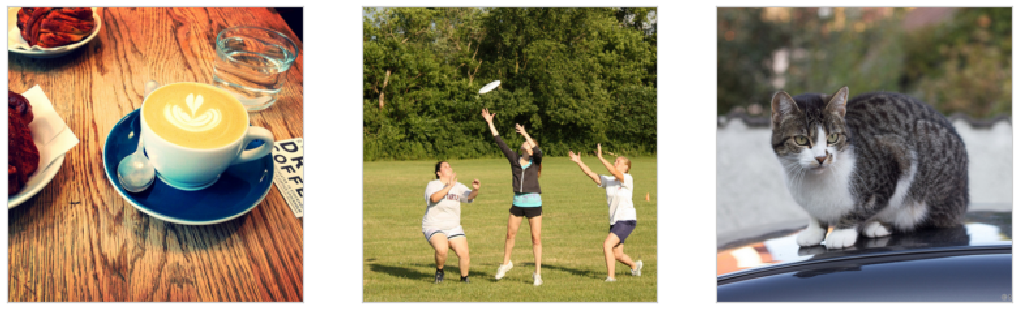

In [9]:
n = 6
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Load Voxels

In [10]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [15]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

#voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_inflated_1.0.nii"%subject)
# voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%subject)

# note we don't seem to have the vcventral mask  - using full brain mask.
voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask.nii.gz"%subject)
voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%subject)
voxel_kast_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(subject))
general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(subject))
ncsnr_full = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%subject)
###
brain_nii_shape = voxel_roi_full.shape
print (brain_nii_shape)
###
voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
# the ROIs defined here are mostly based on pRF mapping - but any voxels which weren't given an ROI definition during the 
# prf mapping, will be given a definition based on Kastner atlas.

###
voxel_mask  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
# taking out the voxels in "other" to reduce the size a bit
voxel_mask_adj = np.copy(voxel_mask)
voxel_mask_adj[np.isin(voxel_joined_roi_full, group[-1])] = False
voxel_mask_adj[np.isin(voxel_joined_roi_full, [-1])] = False


voxel_mask  = voxel_mask_adj

voxel_idx   = np.arange(len(voxel_mask))[voxel_mask]
voxel_roi   = voxel_joined_roi_full[voxel_mask]
voxel_ncsnr = ncsnr_full.flatten()[voxel_mask]
        
print ('full mask length = %d'%len(voxel_mask))
print ('selection length = %d'%np.sum(voxel_mask))
    
vox_total = 0
for roi_mask, roi_name in iterate_roi(group, voxel_roi, roi_map, group_name=group_names):
    vox_total = vox_total + np.sum(roi_mask)
    print ("%d \t: %s" % (np.sum(roi_mask), roi_name))
    
print ("%d \t: Total" % (vox_total))

## NOW decide which to actually analyze here (one at a time for testing)
group2do='V1'
groupind = [ii for ii in range(len(group_names)) if group_names[ii]==group2do]
groupind = groupind[0]

voxel_mask_this_roi = np.zeros(np.shape(voxel_mask)).astype('bool')
voxel_mask_this_roi[np.isin(voxel_joined_roi_full, group[groupind])] = True

print('\nrunning model for %s, %d voxels'%(group_names[groupind], np.sum(voxel_mask_this_roi)))


(81, 104, 83)
full mask length = 699192
selection length = 11694
2392 	: V1
2096 	: V2
1674 	: V3
721 	: hV4
965 	: V3ab
488 	: LO
2155 	: IPS
482 	: VO
382 	: PHC
284 	: MT
55 	: MST
0 	: other
11694 	: Total

running model for V1, 2392 voxels


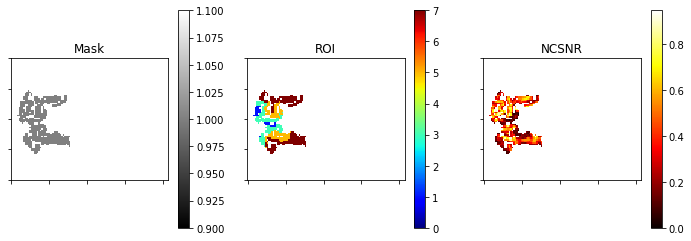

In [9]:
slice_idx = 35
plt.figure(figsize=(12, 4))
    
# saving out little nifti files to the session directory
volume_brain_mask = view_data(brain_nii_shape, voxel_idx, np.ones_like(voxel_idx), save_to=output_dir+"subj%02d_mask"%subject)
# volume_brain_roi  = view_data(brain_nii_shape, voxel_idx, voxel_roi, save_to=output_dir+"subj%02d_roi"%subject)
volume_brain_roi  = view_data(brain_nii_shape, voxel_idx, voxel_roi, save_to=output_dir+"subj%02d_roi"%subject)
volume_ncsnr      = view_data(brain_nii_shape, voxel_idx, voxel_ncsnr, save_to=output_dir+"subj%02d_ncsnr"%subject) 
##
plt.subplot(1,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,2)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.clim([0,7])
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,3)
plt.imshow(volume_ncsnr[:,:,slice_idx], cmap='hot', interpolation='None')
plt.title('NCSNR')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [39]:
voxel_mask_this_roi

array([False, False, False, ..., False, False, False])

In [10]:
beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)


from src.load_nsd import load_betas
voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask_this_roi, up_to=1, load_ext=".nii")
# voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask, up_to=2, load_ext=".nii")
print (voxel_data.shape)

/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.nii.gz
int16 -32768 32767 (750, 81, 104, 83)
<beta> = 1.076, <sigma> = 1.459
(750, 2392)


## Training/validation data split

In [11]:
from src.load_nsd import image_uncolorize_fn, data_split

data_size, nv = voxel_data.shape 
trn_stim_data, trn_voxel_data,\
val_stim_single_trial_data, val_voxel_single_trial_data,\
val_stim_multi_trial_data, val_voxel_multi_trial_data = \
    data_split(image_uncolorize_fn(image_data), voxel_data, ordering, imagewise=False)

# inputs to data_split are images, [nImages x 3 x nPixels x nPixels]
# voxel data, [nTrials x nVoxels]
# ordering which is [nTrialsTotal x 1] and describes index into the images array 0-nImages

# returns training and validation splits, where "shared 1000" images are always validation.

Total number of voxels = 2392


3000

In [257]:
np.shape(val_stim_single_trial_data)

(62, 1, 227, 227)

In [258]:
np.shape(trn_stim_data)

(688, 1, 227, 227)

In [259]:
trn_stim_mean = np.mean(trn_stim_data, axis=(0,2,3), keepdims=True)
print (trn_stim_mean)

[[[[0.46145457]]]]


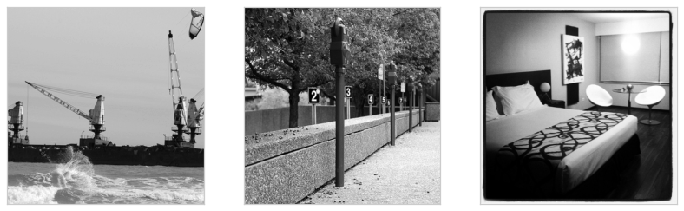

In [260]:
n = 6
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(trn_stim_data[n+i,0], cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Create model
By arbitrary convention, all variables, ojects or functions that return either of those on the device will begin with an underscore.

In [44]:
# from src.torch_fwrf import get_value, set_value
# from src.gabor_feature_extractor import Gaborizer
# from src.rf_grid import linspace, logspace

In [12]:
class add_nonlinearity(L.Module):
    def __init__(self, _fmaps_fn, _nonlinearity):
        super(add_nonlinearity, self).__init__()
        self.fmaps_fn = _fmaps_fn
        self.nl_fn = _nonlinearity
    def forward(self, _x):
        return [self.nl_fn(_fm) for _fm in self.fmaps_fn(_x)]

In [192]:

## Custom gaborizer with reflected padding instead of zeros.

# from src.gabor_feature_extractor import Gaborizer

n_ori=36
cyc_per_stim = logspace(12)(3., 72.) # 6-92
_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=4.13, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

_fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

torch.Size([36, 1, 12, 12])
torch.Size([36, 1, 12, 12])


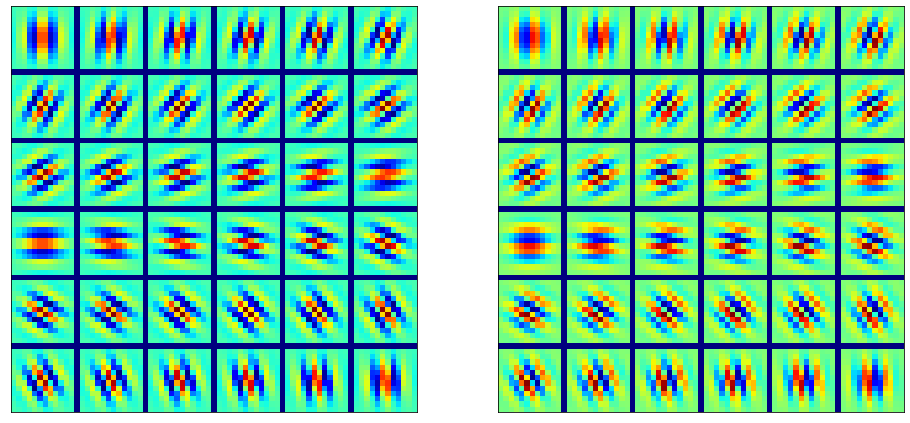

In [144]:
# Printing real and complex parts of the filters: 90 deg out of phase.

for _p in _fmaps_fn.parameters():
    print (_p.size())
##
plt.figure(figsize=(16,8))
for k,_p in enumerate(_fmaps_fn.parameters()):
    plt.subplot(1,2,k+1)
    plt.imshow(pnu.mosaic_vis(get_value(_p)[:,0], pad=1), interpolation='None', cmap='jet')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  

In [181]:
# just to measure the size of these...pass a bit of the data through Gaborizer and get out tensor for each feature map.
_x = torch.tensor(trn_stim_data[:10]).to(device) # the input variable.
_fmaps = _gaborizer(_x)

for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([10, 36, 13, 13])
torch.Size([10, 36, 18, 18])
torch.Size([10, 36, 23, 23])
torch.Size([10, 36, 30, 30])
torch.Size([10, 36, 40, 40])
torch.Size([10, 36, 54, 54])
torch.Size([10, 36, 71, 71])
torch.Size([10, 36, 95, 95])
torch.Size([10, 36, 126, 126])
torch.Size([10, 36, 168, 168])
torch.Size([10, 36, 224, 224])
torch.Size([10, 36, 298, 298])


(36, 13, 13)
(36, 18, 18)
(36, 23, 23)
(36, 30, 30)
(36, 40, 40)
(36, 54, 54)
(36, 71, 71)
(36, 95, 95)
(36, 126, 126)
(36, 168, 168)
(36, 224, 224)


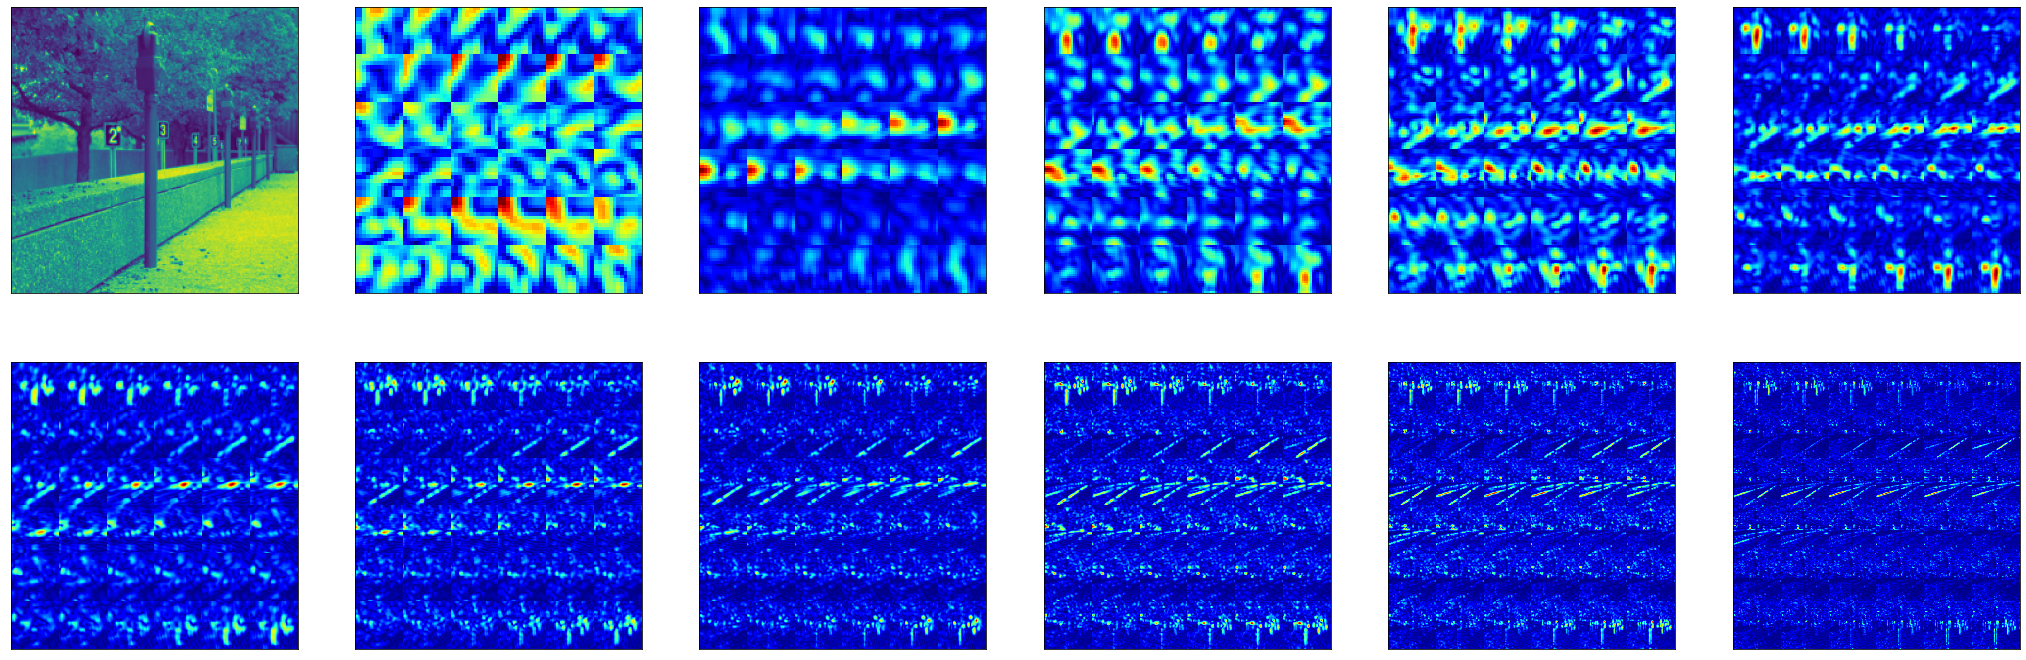

In [182]:

plt.figure(figsize=(36,12))
image_ind=7
plt.subplot(2,6,1)
plt.imshow(np.squeeze(trn_stim_data[image_ind]))
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)  

for k,_fm in enumerate(_fmaps[:11]):
    plt.subplot(2,6,k+2)
    plt.imshow(pnu.mosaic_vis(get_value(_fm)[image_ind], pad=0), interpolation='None', cmap='jet')
    print(np.shape(get_value(_fm)[image_ind]))
    
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  

In [149]:
sfs = np.array(_gaborizer.feature_table['cycles per stimulus'])
orients = np.array(_gaborizer.feature_table['orientation'])


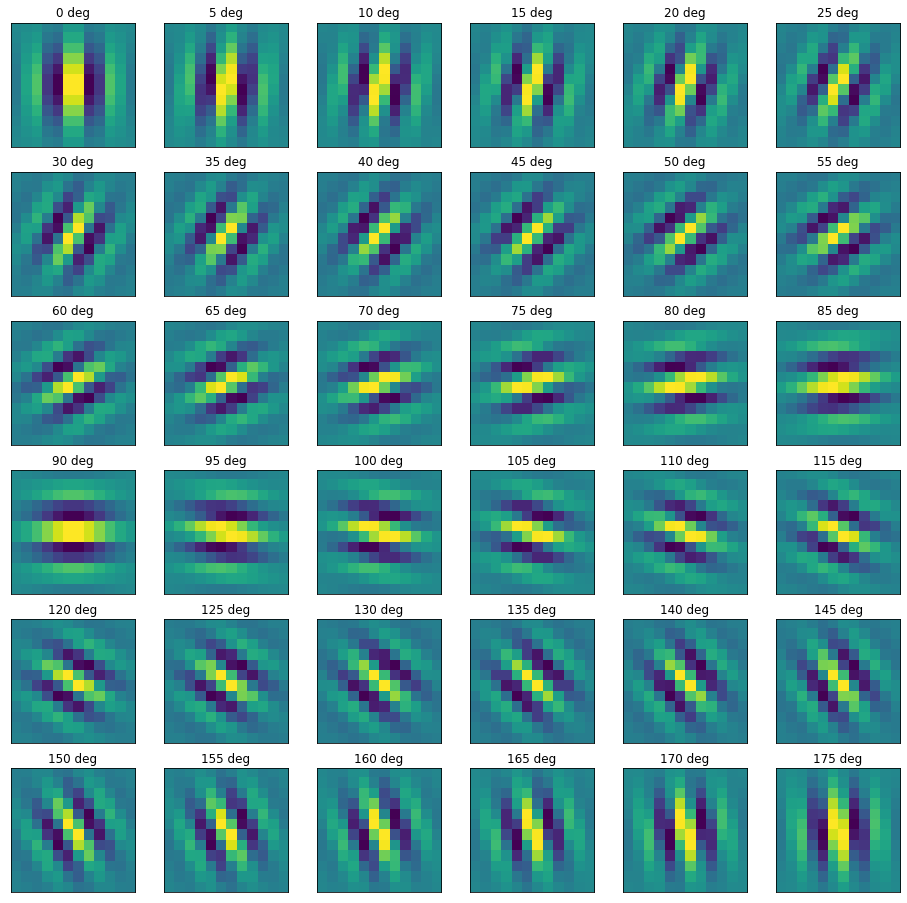

In [150]:
# Visualizing the actual filters

np.shape(_gaborizer.filter_stack_expanded)
all_filters = _gaborizer.filter_stack_expanded
nfilterstotal = np.shape(_gaborizer.filter_stack_expanded)[0]
uniq_filters = _gaborizer.filter_stack_expanded[np.arange(0, nfilterstotal, nfilterstotal/_gaborizer.num_orientations).astype(int),:,:,:]
        
# uniq_filters = np.unique(_gaborizer.filter_stack_expanded, axis=0)
np.shape(uniq_filters)
orients_deg  = np.round(np.unique(orients/np.pi*180),1)

plt.figure(figsize=(16,16));
for ff in range(36):
    
    plt.subplot(6,6,ff+1)
#     plt.imshow(np.real(np.squeeze(all_filters[ff,0,:,:])))
    plt.imshow(np.real(np.squeeze(uniq_filters[ff,0,:,:])))
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title('%d deg'%orients_deg[ff])

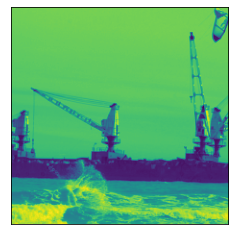

In [183]:
plt.figure();
image_ind = 6
plt.imshow(np.squeeze(trn_stim_data[image_ind]))
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)  

12
(36, 18, 18)
(10, 36, 18, 18)


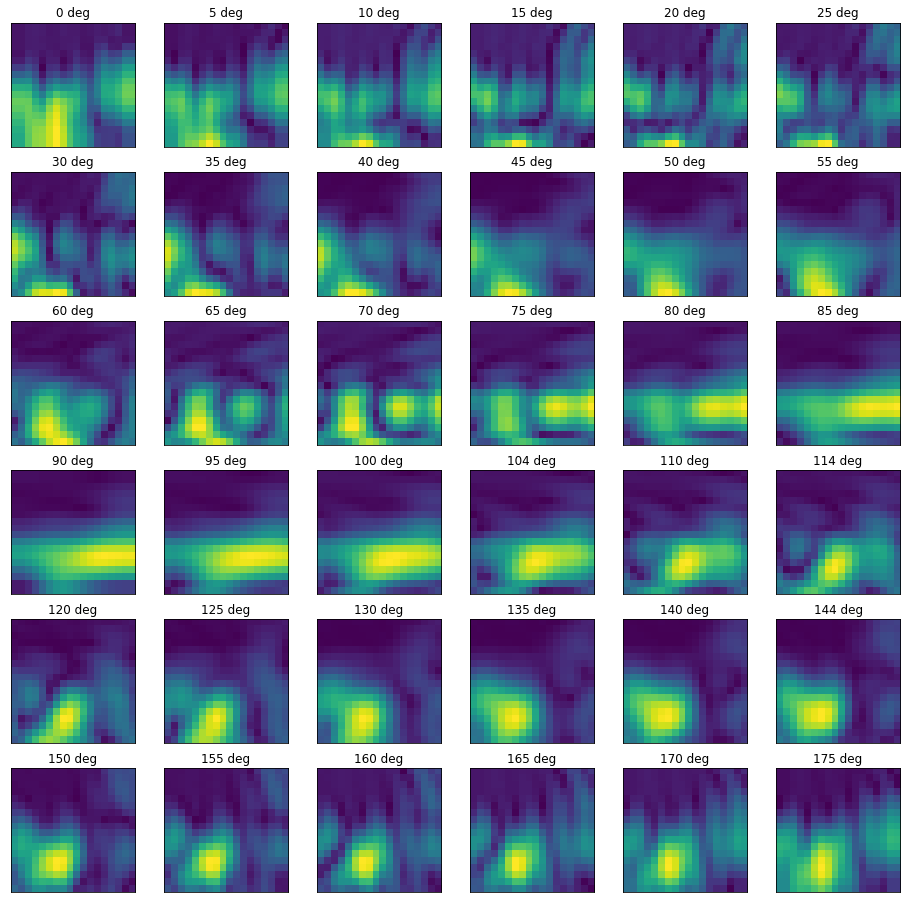

In [152]:
plt.figure(figsize=(16,16))

sf_ind = 1
these_maps = get_value(_fmaps[sf_ind])[image_ind]
print(len(_fmaps))
print(np.shape(these_maps))
print(np.shape(get_value(_fmaps[sf_ind])))
orients_deg = np.unique(np.array(_gaborizer.feature_table['orientation']))/np.pi*180

for orient in range(np.shape(these_maps)[0]):
    
    
    plt.subplot(6,6,orient+1)
    plt.imshow(these_maps[orient,:,:])
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title('%d deg'%orients_deg[orient])
    

In [184]:
# del voxel_data
# del image_data

# import gc
# gc.collect()

# this is just to get the tuning_masks
# from src.torch_feature_space import filter_dnn_feature_maps
# I used image_data because the repeats are not relevant
# _, lmask, fmask, tuning_masks = filter_dnn_feature_maps(trn_stim_data, _fmaps_fn, batch_size=10, fmap_max=512)

from src.torch_feature_space import get_tuning_masks
nSF = len(cyc_per_stim)
num_feat_each_group = n_ori*np.ones([nSF]).astype(int)
partitions = [0,]
for r in num_feat_each_group:
    partitions += [partitions[-1]+r,]
# creating a list of ranges into the total number of maps - these ranges describe the maps corresponding to each layer.
layer_rlist = [range(start,stop) for start,stop in zip(partitions[:-1], partitions[1:])] # the frequency ranges list
fmaps_count = np.sum(num_feat_each_group)
tuning_masks = get_tuning_masks(layer_rlist, fmaps_count)
lmask = [[ii] for ii in np.arange(0,nSF)[::-1]]
fmask = [np.arange(0,n_ori,1) for ii in np.arange(0,nSF)]

print(np.shape(lmask))
print(np.shape(fmask))
print(np.shape(tuning_masks))

#  fmask is [n layer groups x layers_per_group]
#  lmask is [n layer groups x 1]
#  tuning masks is [n layer groups x n total features]
# where layer groups are the diff spatial resolutions. 



(12, 1)
(12, 36)
(12, 432)


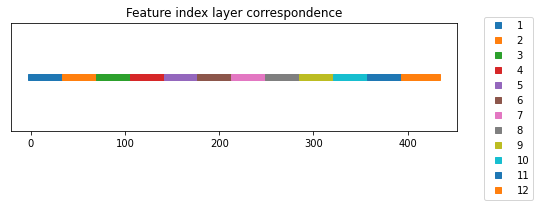

In [154]:
# "Layers" here are the stacks of feature maps with different resolutions for detecting diff SFs.
# x-axis (index) is the full list of features (nOrients x nSF)
# The order of features in full list has SF in chunks, so has a chunked correspondence to the "layers".

plt.figure(figsize=(8, 2))
for k,tm in enumerate(tuning_masks):
    _=plt.plot(tm, marker='s', linestyle='None', label=k+1)
_=plt.title('Feature index layer correspondence')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.1))

# fwRF training procedure
The model is
$$ r(t) = b + W * [f(\int_\mathrm{space}\phi(x,y,t) * g(x,y) dxdy) - m] / \sigma $$
where
$g(x,y)$ is a gaussian pooling field shared by all feature maps

$\phi(x,y,t)$ are the feature maps corresponding to stimuli $t$

$W, b$ are the feature weights and bias of the linearized model for each voxels

$f(\cdot)$ is an optional nonlinearity

$m,\sigma$ are normalization coefficient to facilitate regularization

In [19]:
from src.rf_grid    import linspace, logspace, model_space, model_space_pyramid
# from src.torch_fwrf import learn_params_ridge_regression, get_predictions

aperture = np.float32(1)
smin, smax = np.float32(0.04), np.float32(0.4)
ns = 8

models = model_space_pyramid(logspace(ns)(smin, smax), min_spacing=1.4, aperture=1.1*aperture)
# models is three columns, x, y, sigma
print ('candidate count = ', len(models))

# sample_batch_size=10
# voxel_batch_size=5
sample_batch_size = 200
voxel_batch_size = 500
holdout_size = 5
lambdas = np.logspace(0.,5.,9, dtype=np.float32)

candidate count =  875


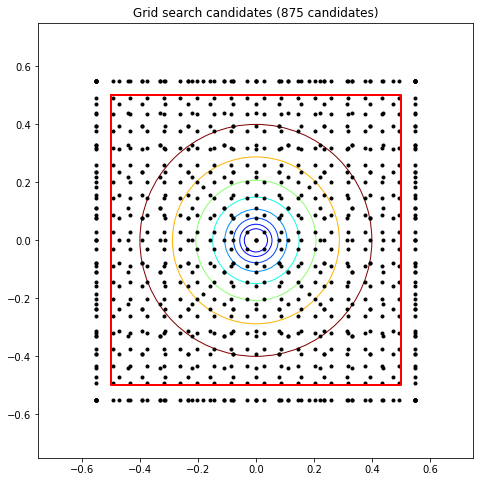

In [188]:
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
import matplotlib.cm as cmx

lx, vx = aperture, aperture * 1.5
cNorm  = colors.Normalize(vmin=.0, vmax=.4)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('jet') )

# within each size value, there's an evenly spaced grid in X-Y space.
# when they are overlaid as in this plot, look really random - but each grid is even when plotted separately.

fig=plt.figure(figsize=(8, 8))
plt.title('Grid search candidates (%d candidates)' % len(models))
plt.plot(models[:,0], models[:,1], '.k', linestyle='None')
ax = plt.gca()
for s in np.unique(models[:,2]):
    ax.add_artist(Ellipse(xy=(0,0), width=2*s, height=2*s, angle=0,
        color=scalarMap.to_rgba(s), lw=1, fill=False))
_=ax.set_xlim(-vx/2, vx/2)
_=ax.set_ylim(-vx/2, vx/2)
_=ax.set_aspect('equal')
plt.plot([-lx/2,lx/2,lx/2,-lx/2,-lx/2], [lx/2,lx/2,-lx/2,-lx/2, lx/2], 'r', lw=2)

In [78]:
filename = output_dir + "rf_grid%s" % (saveext)
fig.savefig(filename, **savearg)
plt.close()

In [85]:
np.shape(_x)

torch.Size([10, 1, 227, 227])

In [128]:
# del _fmaps
# del _x
# del _p
# del _gaborizer

In [20]:
pars = torch.load('/user_data/mmhender/nsd-master/output/S01/gabor_fwrf_May-02-2021_1953/model_params')

pars

{'lmask': [[1], [0]],
 'fmask': [array([0, 1, 2]), array([0, 1, 2])],
 'tuning_masks': [array([ True,  True,  True, False, False, False]),
  array([False, False, False,  True,  True,  True])],
 'cyc_per_stim': array([ 3., 72.], dtype=float32),
 'orients_deg': array([  0.,  60., 120.]),
 'aperture': 1.0,
 'voxel_mask': array([False, False, False, ..., False, False, False]),
 'brain_nii_shape': array([ 81, 104,  83]),
 'image_order': array([ 625, 5012, 4849, ..., 4840, 7322, 9971], dtype=uint16),
 'voxel_index': array([267967, 268049, 268131, ..., 501532, 510162, 510163]),
 'voxel_roi': array([13., 13., 13., ..., 13., 13., 13.]),
 'best_params': [array([[-0.49210526, -0.55      ,  0.04      ],
         [-0.49210526, -0.55      ,  0.04      ],
         [-0.49210526, -0.55      ,  0.04      ],
         ...,
         [-0.49210526, -0.55      ,  0.04      ],
         [-0.49210526, -0.55      ,  0.04      ],
         [-0.55      , -0.55      ,  0.04      ]]),
  array([[-7.2999814e-05,  8.6092

In [16]:

from src.torch_fwrf import get_value, set_value
from src.rf_grid import linspace, logspace

n_ori=36
cyc_per_stim = logspace(12)(3., 72.) # 6-92
_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=4.13, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

_fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

import gc
gc.collect()
torch.cuda.empty_cache()

sample_batch_size=100
voxel_batch_size=100
holdout_pct = 0.10
holdout_size = int(np.ceil(np.shape(trn_voxel_data)[0]*holdout_pct))

best_losses, best_lambdas, best_params = learn_params_ridge_regression(
    trn_stim_data, trn_voxel_data, _fmaps_fn, models, lambdas, \
    aperture=aperture, _nonlinearity=None, zscore=True, sample_batch_size=sample_batch_size, \
    voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=False, add_bias=True)



NameError: name 'Gaborizer' is not defined

In [59]:
torch.cuda.empty_cache()
print_cuda_space(device)
print_cuda_obj(device)


11.55472 GB total
10.26136 GB reserved (cached)
9.97573 GB allocated
1.57899 GB free

<class 'torch.Tensor'> torch.Size([2, 36, 298, 298]) cuda:0 72
<class 'torch.Tensor'> torch.Size([13, 13]) cuda:0 72
<class 'torch.Tensor'> torch.Size([18, 18]) cuda:0 72
<class 'torch.Tensor'> torch.Size([23, 23]) cuda:0 72
<class 'torch.Tensor'> torch.Size([30, 30]) cuda:0 72
<class 'torch.Tensor'> torch.Size([40, 40]) cuda:0 72
<class 'torch.Tensor'> torch.Size([54, 54]) cuda:0 72
<class 'torch.Tensor'> torch.Size([71, 71]) cuda:0 72
<class 'torch.Tensor'> torch.Size([95, 95]) cuda:0 72
<class 'torch.Tensor'> torch.Size([126, 126]) cuda:0 72
<class 'torch.Tensor'> torch.Size([168, 168]) cuda:0 72
<class 'torch.Tensor'> torch.Size([224, 224]) cuda:0 72
<class 'torch.Tensor'> torch.Size([298, 298]) cuda:0 72
<class 'torch.Tensor'> torch.Size([100, 1, 227, 227]) cuda:0 72
<class 'torch.Tensor'> torch.Size([100, 36, 224, 224]) cuda:0 72
<class 'torch.Tensor'> torch.Size([100, 36, 168, 168]) cuda:0 72


In [ ]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from tqdm import tqdm
import pickle
import math

import src.numpy_utility as pnu

import torch
import torch.nn as nn
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim
from src.numpy_utility import iterate_range

def get_value(_x):
    return np.copy(_x.data.cpu().numpy())

def set_value(_x, x):
    if list(x.shape)!=list(_x.size()):
        _x.resize_(x.shape)
    _x.data.copy_(torch.from_numpy(x))
    
def _to_torch(x, device=None):
    return torch.from_numpy(x).float().to(device)        


def learn_params_ridge_regression(data, voxels, _fmaps_fn, models, lambdas, aperture=1.0, _nonlinearity=None, zscore=False, sample_batch_size=100, 
                                  voxel_batch_size=100, holdout_size=100, shuffle=True, add_bias=False):
    """
    Learn the parameters of the fwRF model

    Parameters
    ----------
    data : ndarray, shape (#samples, #channels, x, y)
        Input image block.
    voxels: ndarray, shape (#samples, #voxels)
        Input voxel activities.
    _fmaps_fn: Torch module
        Torch module that returns a list of torch tensors.
    models: ndarray, shape (#candidateRF, 3)
        The (x, y, sigma) of all candidate RFs for gridsearch.
    lambdas: ndarray, shape (#candidateRegression)
        The rigde parameter candidates.
    aperture (default: 1.0): scalar
        The span of the stimulus in the unit used for the RF models.
    _nonlinearity (default: None)
        A nonlinearity expressed with torch's functions.
    zscore (default: False)
        Whether to zscore the feature maps or not.
    sample_batch_size (default: 100)
        The sample batch size (used where appropriate)
    voxel_batch_size (default: 100) 
        The voxel batch size (used where appropriate)
    holdout_size (default: 100) 
        The holdout size for model and hyperparameter selection
    shuffle (default: True)
        Whether to shuffle the training set or not.
    add_bias (default: False)
        Whether to add a bias term to the rigde regression or not.

    Returns
    -------
    losses : ndarray, shape (#voxels)
        The final loss for each voxel.
    lambdas : ndarray, shape (#voxels)
        The regression regularization index for each voxel.
    models : ndarray, shape (#voxels, 3)
        The RF model (x, y, sigma) associated with each voxel.
    params : list of ndarray, shape (#voxels, #features)
        Can contain a bias parameter of shape (#voxels) if add_bias is True.
    mst_mean : ndarray, shape (#voxels, #feature)
        None if zscore is False. Otherwise returns zscoring average per feature.
    mst_std : ndarray, shape (#voxels, #feature)
        None if zscore is False. Otherwise returns zscoring std.dev. per feature.
    """
    def _cofactor_fn(_x, lambdas):
        '''
        Generating a matrix needed to solve ridge regression model for each lambda value.
        Ridge regression (Tikhonov) solution is :
        w = (X^T*X + I*lambda)^-1 * X^T * Y
        This func will return (X^T*X + I*lambda)^-1 * X^T. 
        So once we have that, can just multiply by training data (Y) to get weights.
        returned size is [nLambdas x nFeatures x nTrials]
        '''
        _f = torch.stack([(torch.mm(torch.t(_x), _x) + torch.eye(_x.size()[1], device=device) * l).inverse() for l in lambdas], axis=0) # [#lambdas, #feature, #feature]       
        return torch.tensordot(_f, _x, dims=[[2],[1]]) # [#lambdas, #feature, #sample]
    
    def _loss_fn(_cofactor, _vtrn, _xout, _vout):
        '''
        Calculate loss given "cofactor" from cofactor_fn, training data, held-out design matrix, held out data.
        returns weights (betas) based on equation
        w = (X^T*X + I*lambda)^-1 * X^T * Y
        also returns loss for these weights w the held out data.
        '''

        _beta = torch.tensordot(_cofactor, _vtrn, dims=[[2], [0]]) # [#lambdas, #feature, #voxel]
        _pred = torch.tensordot(_xout, _beta, dims=[[1],[1]]) # [#samples, #lambdas, #voxels]
        _loss = torch.sum(torch.pow(_vout[:,None,:] - _pred, 2), dim=0) # [#lambdas, #voxels]
        return _beta, _loss

    
        #############################################################################
    print('inside new fn')
    dtype = data.dtype.type
    device = next(_fmaps_fn.parameters()).device
    devices = list_cuda_devs()
    trn_size = len(voxels) - holdout_size
    assert trn_size>0, 'Training size needs to be greater than zero'
    print ('trn_size = %d (%.1f%%)' % (trn_size, float(trn_size)*100/len(voxels)))
    print ('dtype = %s' % dtype)
    print ('device = %s' % device)
    print_cuda_space(device)
    print_cuda_obj(device)
    print ('---------------------------------------')
    # shuffle
    nt = len(data)
    nm = len(models)
    nv = voxels.shape[1]
    order = np.arange(len(voxels), dtype=int)
    if shuffle:
        np.random.shuffle(order)
    data   = data[order]
    voxels = voxels[order]  
    trn_voxels = voxels[:trn_size]
    out_voxels = voxels[trn_size:]
    ### Calculate total feature count
#     nf=72
    nf = 0
    _fmaps = _fmaps_fn(_to_torch(data[:2], device=device))

    fmaps_rez = []
    for k,_fm in enumerate(_fmaps):
        nf += _fm.size()[1]
        assert _fm.size()[2]==_fm.size()[3], 'All feature maps need to be square'
        fmaps_rez += [_fm.size()[2],]
        print (_fm.size())    
    print ('---------------------------------------')
    
    del _fmaps
    torch.cuda.empty_cache()
    #############################################################################        
    ### Create full model value buffers    
    best_models = np.full(shape=(nv,), fill_value=-1, dtype=int)   
    best_lambdas = np.full(shape=(nv,), fill_value=-1, dtype=int)
    best_losses = np.full(fill_value=np.inf, shape=(nv), dtype=dtype)
    best_w_params = np.zeros(shape=(nv, nf), dtype=dtype)
    if add_bias:
        best_w_params = np.concatenate([best_w_params, np.ones(shape=(len(best_w_params),1), dtype=dtype)], axis=1)
    mst_mean = None
    mst_std = None
    if zscore:
        mst_mean = np.zeros(shape=(nv, nf), dtype=dtype)
        mst_std  = np.zeros(shape=(nv, nf), dtype=dtype)
    
    start_time = time.time()
    vox_loop_time = 0
    print ('')
    with torch.no_grad():
        
        # Looping over models (here models are different spatial RF definitions)
        for m,(x,y,sigma) in enumerate(models):
#             if m>1:
#                 break
            print('\nStarting model %d of %d - making features'%(m, len(models)))

            mst = np.zeros(shape=(nt, nf), dtype=dtype)
    
            # Define the RF for this "model" version - at several resolutions.
            
            _pfs = [_to_torch(pnu.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, dtype=dtype)[2], device=device) for n_pix in fmaps_rez]
            print('_pfs:')
            print(_pfs[-1].shape)
            # To make full design matrix for all trials, first looping over trials in batches to get the features
            # Only reason to loop is memory constraints, because all trials is big matrices.
            t = time.time()
            for rt,rl in iterate_range(0, nt, sample_batch_size):
                
                # multiplying feature maps by RFs here. 
                # we have one specified RF position for this version of the model. 
                # Feature maps in _fm go [nTrials x nFeatures(orientations) x nPixels x nPixels]
                # spatial RFs in _pf go [nPixels x nPixels]
                # purpose of the for looping within this statement is to loop over map resolutions (e.g. spatial frequencies in model)
                # output _mst is [nTrials x nFeatures*nResolutions], so a 2D matrix. 
                # Combining features/resolutions here finally, so we can solve for weights in that full orient x SF feature space.

                # then combine this with the other "batches" of trials to make a full "model space tensor"
                # mst is [nTrialsTotal x nFeatures*nResolutions]
                print('getting features for trials %d:%d'%(rt[0], rt[-1]))
                print_cuda_space(device)
                print_cuda_obj(device)
#                 _mst1 = []
#                 for sf, _pf in enumerate(_pfs):
#                     _fm = _fmaps_fn(_to_torch(data[rt], device=device))
#                     _mst1 = torch.cat([_mst1, torch.tensordot(_fm, _pf, dims=[[2,3], [0,1]])], dim=1)
                
                _mst = torch.cat([torch.tensordot(_fm, _pf, dims=[[2,3], [0,1]]) for _fm,_pf in zip(_fmaps_fn(_to_torch(data[rt], device=device)), _pfs)], dim=1) # [#samples, #features]
                print('_mst:')
                print(_mst.shape)
        #                 assert(_mst1==_mst2)
#                 _mst = _mst1
#                 print('methods are same')
                if _nonlinearity is not None:
                    _mst = _nonlinearity(_mst)
                
                # Add features for this batch to full design matrix over all trias
                mst[rt] = get_value(_mst)
            elapsed = time.time() - t
            print('design matrix took %.2f'%elapsed)
            
            if zscore:  
                mstm = np.mean(mst, axis=0, keepdims=True) #[:trn_size]
                msts = np.std(mst, axis=0, keepdims=True) + 1e-6          
                mst -= mstm
                mst /= msts    
                
            if add_bias:
                mst = np.concatenate([mst, np.ones(shape=(len(mst), 1), dtype=dtype)], axis=1)
            
            # separate design matrix into training/held out data (for lambda selection)
            trn_mst = mst[:trn_size]
            out_mst = mst[trn_size:]   

            # Send matrices to gpu
            _xtrn = _to_torch(trn_mst, device=device)
            _xout = _to_torch(out_mst, device=device)   
            
            # Do part of the matrix math involved in ridge regression optimization out of the loop, 
            # because this part will be same for all the voxels.
            _cof = _cofactor_fn(_xtrn, lambdas)
            
            # Now looping over batches of voxels (only reason is because can't store all in memory at same time)
            vox_start = time.time()
            for rv,lv in iterate_range(0, nv, voxel_batch_size):
#                 sys.stdout.write('\rfitting model %4d of %-4d, voxels [%6d:%-6d] of %d' % (m, nm, rv[0], rv[-1], nv))

                # Send matrices to gpu
                _vtrn = _to_torch(trn_voxels[:,rv], device=device)
                _vout = _to_torch(out_voxels[:,rv], device=device)
            
#                 print_cuda_space(device)
#                 print_cuda_obj(device)
                # Here is where optimization happens - relatively simple matrix math inside loss fn.
                _betas, _loss = _loss_fn(_cof, _vtrn, _xout, _vout) #   [#lambda, #feature, #voxel, ], [#lambda, #voxel]
                # Now have a set of weights (in betas) and a loss value for every voxel and every lambda. 
                # goal is then to choose for each voxel, what is the best lambda and what weights went with that lambda.

                # first choose best lambda value and the loss that went with it.
                _values, _select = torch.min(_loss, dim=0)
                betas = get_value(_betas)
                values, select = get_value(_values), get_value(_select)

                # comparing this loss to the other models for each voxel (e.g. the other RF position/sizes)
                imp = values<best_losses[rv]

                if np.sum(imp)>0:
                    # for whichever voxels had improvement relative to previous models, save parameters now
                    # this means we won't have to save all params for all models, just best.
                    arv = np.array(rv)[imp]
                    li = select[imp]
                    best_lambdas[arv] = li
                    best_losses[arv] = values[imp]
                    best_models[arv] = m
                    if zscore:
                        mst_mean[arv] = mstm # broadcast over updated voxels
                        mst_std[arv]  = msts
                    # taking the weights associated with the best lambda value
                    best_w_params[arv,:] = pnu.select_along_axis(betas[:,:,imp], li, run_axis=2, choice_axis=0).T
                    
            vox_loop_time += (time.time() - vox_start)
            elapsed = (time.time() - vox_start)
            print('solving for weights in voxel loop took %.2f'%elapsed)
    #############################################################################   
    total_time = time.time() - start_time
    inv_time = total_time - vox_loop_time
    return_params = [best_w_params[:,:nf],]
    if add_bias:
        return_params += [best_w_params[:,-1],]
    else: 
        return_params += [None,]
    print ('\n---------------------------------------')
    print ('total time = %fs' % total_time)
    print ('total throughput = %fs/voxel' % (total_time / nv))
    print ('voxel throughput = %fs/voxel' % (vox_loop_time / nv))
    print ('setup throughput = %fs/model' % (inv_time / nm))
    sys.stdout.flush()
    return best_losses, best_lambdas, [models[best_models],]+return_params+[mst_mean, mst_std]



class Torch_fwRF_voxel_block(nn.Module):
    '''
    This is a variant of the fwRF model as a module for a voxel block (we can't have it all at once)
    Initialize with one set of voxels, but can use load_voxel_block to run w different batches
    '''

    def __init__(self, _fmaps_fn, params, _nonlinearity=None, input_shape=(1,3,227,227), aperture=1.0):
        super(Torch_fwRF_voxel_block, self).__init__()
        
        self.aperture = aperture
        models, weights, bias, mstmt, mstst = params
        device = next(_fmaps_fn.parameters()).device
        _x =torch.empty((1,)+input_shape[1:], device=device).uniform_(0, 1)
        _fmaps = _fmaps_fn(_x)
        self.fmaps_rez = []
        for k,_fm in enumerate(_fmaps):
            assert _fm.size()[2]==_fm.size()[3], 'All feature maps need to be square'
            self.fmaps_rez += [_fm.size()[2],]
        
        self.pfs = []
        for k,n_pix in enumerate(self.fmaps_rez):
            pf = pnu.make_gaussian_mass_stack(models[:,0], models[:,1], models[:,2], n_pix, size=aperture, dtype=np.float32)[2]
            self.pfs += [nn.Parameter(torch.from_numpy(pf).to(device), requires_grad=False),]
            self.register_parameter('pf%d'%k, self.pfs[-1])
            
        self.weights = nn.Parameter(torch.from_numpy(weights).to(device), requires_grad=False)
        self.bias = None
        if bias is not None:
            self.bias = nn.Parameter(torch.from_numpy(bias).to(device), requires_grad=False)
            
        self.mstm = None
        self.msts = None
        if mstmt is not None:
            self.mstm = nn.Parameter(torch.from_numpy(mstmt.T).to(device), requires_grad=False)
        if mstst is not None:
            self.msts = nn.Parameter(torch.from_numpy(mstst.T).to(device), requires_grad=False)
        self._nl = _nonlinearity
              
    def load_voxel_block(self, *params):
        models = params[0]
        for _pf,n_pix in zip(self.pfs, self.fmaps_rez):
            pf = pnu.make_gaussian_mass_stack(models[:,0], models[:,1], models[:,2], n_pix, size=self.aperture, dtype=np.float32)[2]
            if len(pf)<_pf.size()[0]:
                pp = np.zeros(shape=_pf.size(), dtype=pf.dtype)
                pp[:len(pf)] = pf
                set_value(_pf, pp)
            else:
                set_value(_pf, pf)
        for _p,p in zip([self.weights, self.bias], params[1:3]):
            if _p is not None:
                if len(p)<_p.size()[0]:
                    pp = np.zeros(shape=_p.size(), dtype=p.dtype)
                    pp[:len(p)] = p
                    set_value(_p, pp)
                else:
                    set_value(_p, p)
        for _p,p in zip([self.mstm, self.msts], params[3:]):
            if _p is not None:
                if len(p)<_p.size()[1]:
                    pp = np.zeros(shape=(_p.size()[1], _p.size()[0]), dtype=p.dtype)
                    pp[:len(p)] = p
                    set_value(_p, pp.T)
                else:
                    set_value(_p, p.T)
 
    def forward(self, _fmaps):
        _mst = torch.cat([torch.tensordot(_fm, _pf, dims=[[2,3], [1,2]]) for _fm,_pf in zip(_fmaps, self.pfs)], dim=1) # [#samples, #features, #voxels] 
        if self._nl is not None:
            _mst = self._nl(_mst)
        if self.mstm is not None:              
            _mst -= self.mstm[None]
        if self.msts is not None:
            _mst /= self.msts[None]
        _mst = torch.transpose(torch.transpose(_mst, 0, 2), 1, 2) # [#voxels, #samples, features]
        _r = torch.squeeze(torch.bmm(_mst, torch.unsqueeze(self.weights, 2))).t() # [#samples, #voxels]
        if self.bias is not None:
            _r += torch.unsqueeze(self.bias, 0)
        return _r


    
def get_predictions(data, _fmaps_fn, _fwrf_fn, params, sample_batch_size=100):
    """
    The predictive fwRF model for arbitrary input image.

    Parameters
    ----------
    data : ndarray, shape (#samples, #channels, x, y)
        Input image block.
    _fmaps_fn: Torch module
        Torch module that returns a list of torch tensors.
        This is defined previously, maps from images to feature maps.
    _fwrf_fn: Torch module
        Torch module that compute the fwrf model for one batch of voxels
        Defined in Torch_fwrf_voxel_block
    params: list including all of the following:
    [
        models : ndarray, shape (#voxels, 3)
            The RF model (x, y, sigma) associated with each voxel.
        weights : ndarray, shape (#voxels, #features)
            Tuning weights
        bias: Can contain a bias parameter of shape (#voxels) if add_bias is True.
           Tuning biases: None if there are no bias
        mst_mean (optional): ndarray, shape (#voxels, #feature)
            None if zscore is False. Otherwise returns zscoring average per feature.
        mst_std (optional): ndarray, shape (#voxels, #feature)
            None if zscore is False. Otherwise returns zscoring std.dev. per feature.
    ]
    sample_batch_size (default: 100)
        The sample batch size (used where appropriate)

    Returns
    -------
    pred : ndarray, shape (#samples, #voxels)
        The prediction of voxel activities for each voxels associated with the input data.
    """
    dtype = data.dtype.type
    device = next(_fmaps_fn.parameters()).device
    _params = [_p for _p in _fwrf_fn.parameters()]
    voxel_batch_size = _params[0].size()[0]    
    nt, nv = len(data), len(params[0])
    #print ('val_size = %d' % nt)
    pred = np.full(fill_value=0, shape=(nt, nv), dtype=dtype)
    start_time = time.time()
    with torch.no_grad():
        ## Looping over voxels here in batches, will eventually go through all.
        for rv, lv in iterate_range(0, nv, voxel_batch_size):
            _fwrf_fn.load_voxel_block(*[p[rv] if p is not None else None for p in params])
            pred_block = np.full(fill_value=0, shape=(nt, voxel_batch_size), dtype=dtype)
            # Now looping over validation set trials in batches
            for rt, lt in iterate_range(0, nt, sample_batch_size):
                sys.stdout.write('\rsamples [%5d:%-5d] of %d, voxels [%6d:%-6d] of %d' % (rt[0], rt[-1], nt, rv[0], rv[-1], nv))
                pred_block[rt] = get_value(_fwrf_fn(_fmaps_fn(_to_torch(data[rt], device)))) 
            pred[:,rv] = pred_block[:,:lv]
    total_time = time.time() - start_time
    print ('\n---------------------------------------')
    print ('total time = %fs' % total_time)
    print ('sample throughput = %fs/sample' % (total_time / nt))
    print ('voxel throughput = %fs/voxel' % (total_time / nv))
    sys.stdout.flush()
    return pred

In [52]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F


def make_2D_sinewave(freq, theta, phase, n_pix):
    '''
    freq is cycles/image
    theta is in radians
    phase is in radians (0 pi)
    center is (x,y) in pixel coordinates
    n_pix is size of the kernel in pixels
    '''
    vec = np.array([np.cos(theta), np.sin(theta)])*2*np.pi*freq / n_pix
    
    [Xm, Ym] = np.meshgrid(np.linspace(-.5*n_pix, .5*n_pix, n_pix), np.linspace(-.5*n_pix, .5*n_pix, n_pix))
    
    proj = np.array([Xm.ravel(), Ym.ravel()]).T.dot(vec)
    
    Dt = np.sin(proj+phase)              # compute proportion of Xm for given orientation
    Dt = Dt.reshape(Xm.shape)
    
    return Dt




def make_gaussian(center, sig, n_pix):
    """
    Make a picture of a circular gaussian blob.
    center is the center of the blob in pixels. center of image is (0,0)
    sig is one std. of the gaussian (pixels)
    n_pix is the size of the picture of the gaussian blob. i.e., output will be an 2D array that is n_pix-by-n_pix
    """
    
    [Xm, Ym] = np.meshgrid(np.linspace(-.5*n_pix, .5*n_pix, n_pix), np.linspace(-.5*n_pix, .5*n_pix, n_pix))
    
    x0 = center[0]
    y0 = center[1]
    
    Z = (1. / (2*np.pi*sig**2))
    
    return Z *np.exp(-((Xm-x0)**2 + (Ym-y0)**2) / (2*sig**2))




def make_gabor(freq, theta, phase, center, sig, n_pix):
    return make_2D_sinewave(freq, theta, phase, n_pix) * make_gaussian(center, sig,n_pix)




def make_complex_gabor(freq, theta, center, sig, n_pix):
    '''
    make_complex_gabor(freq, theta, center, sig, n_pix)
    freq is spatial frequency in cycles/image
    theta is orientation in radians
    center is (x,y) in pixel coordinates. center of image is (0,0)
    sig is one std of the gaussian envelope (pixels)
    n_pix is size of the kernel in pixels
    
    '''
    phase = 0
    on_gabor = make_gabor(freq, theta, phase, center, sig, n_pix)
    phase = np.pi/2.
    off_gabor = make_gabor(freq, theta, phase, center, sig, n_pix)
    
    return off_gabor + 1j*on_gabor




def make_feature_table(num_orientations, cycles_per_stim,
                     freq_spacing='log', pix_per_cycle=2, cycles_per_radius=1, 
                     radii_per_filter=4, complex_cell=True):
    '''
    Generates a table of parameters used to apply a gabor transform.
    This approach assumes that the gabors will be of fixed size (in pixels), but the image
    the gabors are applied to are downsampled, effectively determining the spatial frequency extracted 
    from the image.
    
    Returns everything needed to construct a stack of gabor filters. 
    
    feature_table, pix_per_filter, cyc_per_filter, envelope_radius_pix =
                                      make_feature_table((num_orientations, 
                                                          cycles_per_stim,
                                                          freq_spacing='log', 
                                                          pix_per_cycle=2, 
                                                          cycles_per_radius=1, 
                                                          radii_per_filter=4, 
                                                          complex_cell=True)
                     
    num_orientations  ~ number of linearly spaced orientations in [0,pi]
    cycles_per_stim   ~ either a tuple specifying range and number of spatial frequencies in cyc/stim 
                        (lowest, highest, num), or an explicit list of spatial frequencies (as np array or list)    
    freq_spacing      ~ log or linear. spacing of spatial frequencies. used only if cycles_per_stim is given as 
                        range. 
    pix_per_cycle     ~ how many pixels will be used to depict one cycle. default = 2, i.e., the Nyquist limit.
                        If too low, will result in jaggy edges or aliasing, but if too high, usually will require 
                        stimuli with larger than native resolution.
    cycles_per_radius ~ determines radius of gaussian envelop. we specify how many cycles the sinewave completes
                        per radius (1std.) of the gaussian envelope. default = 1 = one cycle of the sinewave per 
                        std. of the gaussian envelope.
    radii_per_filter  ~ determines the size of the filter. we specify how many radii (1std. each) of the gaussian
                        envelope fits inside of the filter. default = 4.
    complex_cell      ~ default = True, meaning that ea. feature map represents a given spatial frequency 
                        that is phase invariant (the absolute value is taken between a pair of feature maps 
                        constructed using filters with 0 and pi/2 phase). if False, we distinguish between 
                        filters with 0 and pi/2 phase, resulting in 2 feature maps for each spatial frequency.
    
    returns
    feature_table        ~ a pandas table with details of each feature to be extracted from images.
    pix_per_filter       ~ number of pixels per filter.  a constant.
    cyc_per_filter       ~ number of cycles per filter.  a constant.
    envelope_radius_pix  ~ number of pixels needed for one std. of the gaussian envelope. a constant.
            
    
    Note: depending on the size of your stimuli and the given parameters, you will be limited to a certain range 
    of spatial frequencies. If the lowest frequency is too low, the filter will be larger than the downsampled 
    image, which is kind of dumb. If the highest frequency is too high, the image will have to be upsampled to 
    obtain the required number of pixels per cycle, which is also dumb (not possible to capture a spatial 
    frequency that is higher than the original resolution of the image). The "full" range will have a lowest 
    frequency where the image is downsampled to the size of the filter, and a highest frequency where the image 
    is not downsampled at all. The larger the number of pixels per cycle, the smaller this range will be.
    
    '''
    
    oris = np.linspace(0, np.pi, num=num_orientations, endpoint=False) 
    
    ##------Sort out spatial frequencies to extract
    assert isinstance(cycles_per_stim, (tuple, list, np.ndarray)), 'cycles_per_stim must either be a tuple of len 3 (min, max, num), or an explicit list of spatial freqs (np array or list)' 
    
    ##if range of freqs given
    if type(cycles_per_stim) is tuple:       
        assert len(cycles_per_stim)==3, 'exactly 3 args required if cycles_per_stim is given as tuple (min, max, num)'
        if freq_spacing == 'log':
            cycles_per_stim = np.logspace(np.log10(cycles_per_stim[0]),np.log10(cycles_per_stim[1]),num=cycles_per_stim[2])
        elif freq_spacing == 'linear':
            cycles_per_stim = np.linspace(cycles_per_stim[0],cycles_per_stim[1],num=cycles_per_stim[2])
    
    #if explicit freqs given
    elif type(cycles_per_stim) is list:     
        cycles_per_stim = np.array(cycles_per_stim)
    elif type(cycles_per_stim) is np.ndarray: 
        pass

    
    ##------Inferred from your choices
    ##radius (1 std) of gaussian envelope of gabor filters in pixels
    envelope_radius_pix = pix_per_cycle * cycles_per_radius

    ##cycles per filter
    cycles_per_filter = cycles_per_radius * radii_per_filter ##should be constant
    
    ##given the num of cycles in a filter and the pix/cyc, this is how big the filter should be in pixels
    pix_per_filter = int(np.round(cycles_per_filter * pix_per_cycle)) ##should be constant
    
    ##given the num of cycles in a stim and the pix/cyc, this is how big the stim should be in pixels
    pix_per_stim = np.round(cycles_per_stim * pix_per_cycle).astype('int')
    

    ##------Construct pandas table of features 
    metrics = {'cycles per stimulus': cycles_per_stim,      
               'pix per stimulus' : pix_per_stim,
               'cycles per filter': cycles_per_filter,
               'pix per filter': pix_per_filter,
               'gauss. env. radius (pix)': envelope_radius_pix}
    
    feature_table = pd.DataFrame(metrics)
    if not complex_cell:
        feature_table['phase'] = 0
        other_feature_table = feature_table.copy()
        other_feature_table['phase'] = np.pi/2.
        feature_table = pd.concat([feature_table,other_feature_table],axis=0,ignore_index=True)
        
    feature_table['orientation'] = oris[0]
    tmp_feature_table = feature_table.copy()
    for o in oris[1:]:
        tmp_feature_table['orientation'] = o
        feature_table = pd.concat([feature_table,tmp_feature_table],axis=0,ignore_index=True)
        
        
    return (feature_table,
            pix_per_filter,     
            cycles_per_filter,  
            envelope_radius_pix) 




def make_filter_stack(feature_table, pix_per_filter, cycles_per_filter, envelope_radius_pix, complex_cell=True, color_channels=1):
    
    ##initialize
    filter_stack = np.zeros((feature_table.shape[0],color_channels, pix_per_filter, pix_per_filter))
    if complex_cell:
        filter_stack = filter_stack+1j
    
    ##args to gaborme
    center = (0,0)
    freq = cycles_per_filter
    radius = np.float32(envelope_radius_pix)
    for ii,tx in enumerate(feature_table.index):
        ori = feature_table.loc[tx,'orientation'] 
        for c in range(color_channels):
            if complex_cell:
                filter_stack[ii,c,:,:] = make_complex_gabor(freq,ori,center,radius,pix_per_filter)
            else:
                ph = feature_table.loc[ii,'phase']
                filter_stack[ii,c,:,:] = make_gabor(freq,ori,ph,center,radius,pix_per_filter)
                
    return filter_stack




class Gaborizer(nn.Module):

    '''
    gaborizer = Gaborizer(num_orientations, 
                          cycles_per_stim,
                          freq_spacing='log', 
                          pix_per_cycle=2, 
                          cycles_per_radius=1, 
                          radii_per_filter=4, 
                          complex_cell=True, 
                          pad_type='half', 
                          crop=False)
                                          
    num_orientations  ~ number of linearly spaced orientations in [0,pi]
    cycles_per_stim   ~ either a tuple specifying range and number of spatial frequencies in cyc/stim 
                        (lowest, highest, num), or an explicit list of spatial frequencies (as np array or list)    
    freq_spacing      ~ log or linear. spacing of spatial frequencies. used only if cycles_per_stim is given as 
                        range. 
    pix_per_cycle     ~ how many pixels will be used to depict one cycle. default = 2, i.e., the Nyquist limit.
                        If too low, will result in jaggy edges or aliasing, but if too high, usually will require 
                        stimuli with larger than native resolution.
    cycles_per_radius ~ determines radius of gaussian envelop. we specify how many cycles the sinewave completes
                        per radius (1std.) of the gaussian envelope. default = 1 = one cycle of the sinewave per 
                        std. of the gaussian envelope.
    radii_per_filter  ~ determines the size of the filter. we specify how many radii (1std. each) of the gaussian
                        envelope fits inside of the filter. default = 4.
    complex_cell      ~ default = True, meaning that ea. feature map represents a given spatial frequency 
                        that is phase invariant (the absolute value is taken between a pair of feature maps 
                        constructed using filters with 0 and pi/2 phase). if False, we distinguish between 
                        filters with 0 and pi/2 phase, resulting in 2 feature maps for each spatial frequency.
    pad_type          ~ determines how much images will be padded before convolution.
                        can be either:
                        'half':  pad input with symmetric border that is filter width//2. if the filter width in 
                        pixels is odd, the convolution output will be the same width as the input. if even, the 
                        output width will be input width + 1. 
                        'full':  applies the filter wherever it partly overlaps with the stim. pads
                        input with symmetric border of filter width - 1. generates output that is 
                        input size + filter size - 1
    crop              ~ default = False. if True, the convolution output is cropped back down to the size of the 
                        resampled input stim. note that in most cases, this would mean part of the convolution 
                        was calculated for no reason. it is therefore recommended that pad_type 'half' is used if
                        feature maps that are close to the size of the input are desired. 
                        
    
    returns
    gaborizer         ~ a torch module that takes an image tensor [num stim, 1, pix, pix] and returns a list 
                        of tensors each representing feature maps of a different spatial frequency 
                        [num stim, num orientations, resampled stim pix, resampled stim pix]. 
                        
                        module parameters: 
                            real_filters_tnsr (Tensor):  [num orientations, 1, pix_per_filter, pix_per_filter] 
                            imag_filters_tnsr (Tensor):  [num orientations, 1, pix_per_filter, pix_per_filter];
                                                         if complex_cell = True
                                                         
                        instance variables include:
                            feature_table:               a pandas table with details of parameters that were set
                                                         to extract each feature 
                            filter_stack_expanded:       all filters (complex if complex_cell=True) used for convolution, 
                                                         repeated along axis=0 to match the complete stack of feature maps. 
                                                         [num oris * num of cyc_per_stim, 1, pix_per_filter, pix_per_filter]
    '''
    
    
    def __init__(self, num_orientations, cycles_per_stim,
                 freq_spacing='log', pix_per_cycle=2, cycles_per_radius=1, 
                 radii_per_filter=4, complex_cell=True, pad_type='half', 
                 crop=False):
     
        super(Gaborizer, self).__init__()
        
        self.num_orientations = num_orientations
        self.freq_spacing = freq_spacing
        self.pix_per_cycle = pix_per_cycle
        self.cycles_per_radius = cycles_per_radius
        self.radii_per_filter = radii_per_filter
        self.complex_cell = complex_cell
        self.pad_type = pad_type
        self.crop=crop
        
        (self.feature_table,
         self.pix_per_filter,
         self.cycles_per_filter,
         self.envelope_radius_pix) = make_feature_table(num_orientations,
                                                        cycles_per_stim,
                                                        freq_spacing,
                                                        pix_per_cycle,
                                                        cycles_per_radius,
                                                        radii_per_filter,
                                                        complex_cell=self.complex_cell)
        
        self.filter_stack_expanded = make_filter_stack(self.feature_table,
                                                       self.pix_per_filter,
                                                       self.cycles_per_filter,
                                                       self.envelope_radius_pix,
                                                       complex_cell=self.complex_cell)
        

        #narrow filter stack down to only unique filters (should = num_orientations)
#         uniq_filters = np.unique(self.filter_stack_expanded, axis=0)
        nfilterstotal = np.shape(self.filter_stack_expanded)[0]
        uniq_filters = self.filter_stack_expanded[np.arange(0, nfilterstotal, nfilterstotal/self.num_orientations).astype(int),:,:,:]
        
        del self.filter_stack_expanded
        torch.cuda.empty_cache()
        
        #split into real and imag gabor filters and represent ea. as tensor 
        if complex_cell:
            self.real_filters_tnsr = nn.Parameter(torch.tensor(np.real(uniq_filters), dtype=torch.float32, requires_grad=True))
            self.imag_filters_tnsr = nn.Parameter(torch.tensor(np.imag(uniq_filters), dtype=torch.float32, requires_grad=True))
        else:
            self.real_filters_tnsr = nn.Parameter(torch.tensor(uniq_filters, dtype=torch.float32, requires_grad=True))
            self.imag_filters_tnsr = None
    
        #from table, get unique stim resolutions (corresponds to the diff. spatial frequencies being extracted)
        stim_sizes = self.feature_table['pix per stimulus'].unique()       
        
        self.lowest_freq = np.min(stim_sizes) 
        self.highest_freq = np.max(stim_sizes) 
        self.num_sp_freq = len(stim_sizes)
        
        #make a list of feature extractors, ea. extracting a diff freq (by resampling image to diff size before conv)
        self.gfe_list = []
        
        for new_dim in stim_sizes:
            
            #create instance of torch feature extractor with the given resampling parameter
            feature_extractor = GaborFeatExtractor(self.real_filters_tnsr, self.imag_filters_tnsr, 
                                                   (new_dim, new_dim), pad_type=self.pad_type, crop=self.crop)
            self.gfe_list.append(feature_extractor)
            
        
        
    def forward(self, minibatch_stim_tnsr):
        
        feature_map_list = []
        
        for n, gfe in enumerate(self.gfe_list):
            
            #for given freq, create feature map for each gabor orientation 
            sing_freq_features = gfe(minibatch_stim_tnsr)   #size [num stim, num orientations, stim pix, stim pix]
            
            #put each feature map tensor into a list of tensors 
            feature_map_list.append(sing_freq_features)

        return feature_map_list 




class GaborFeatExtractor(nn.Module):    
    def __init__(self, real_filters_tnsr, imag_filters_tnsr, new_dim, pad_type='half', crop=False):
        super(GaborFeatExtractor, self).__init__()
        
        self.real_filters_tnsr = real_filters_tnsr
        self.imag_filters_tnsr = imag_filters_tnsr
        self.pad_type = pad_type
        self.crop = crop
        
        #this will be the stimulus resampling function 
        self.resam = torch.nn.Upsample(new_dim, mode="bilinear")
        
    def forward(self, minibatch_stim_tnsr):
        
        #resize stimuli
        resampled_stim_stack = self.resam(minibatch_stim_tnsr)
        input_sz = resampled_stim_stack.shape[2]
        
        #sort out stimulus padding
        assert self.pad_type in ['half', 'full'], 'pad_type must be either \'half\' or \'full\''
        if self.pad_type is 'half':
            pad_sz = self.real_filters_tnsr.shape[2]//2       #pad input w/ sym. border that is the floor the filter width/2
        else:
            pad_sz = self.real_filters_tnsr.shape[2] - 1      #apply filter wherever it partly overlaps with the input

       
#       real_feature_map_tnsr = F.conv2d(resampled_stim_stack, self.real_filters_tnsr, stride=1, padding=pad_sz) 

        nsamples = minibatch_stim_tnsr.shape[0]
        nfilters = self.real_filters_tnsr.shape[0]
        filter_size = self.real_filters_tnsr.shape[2]
        device = minibatch_stim_tnsr.get_device()
        
        del minibatch_stim_tnsr 
        torch.cuda.empty_cache()
        
        #convolve stim with filters (returns feat maps of size [num stim, num orientations, stim pix, stim pix])
        # creating a conv2d layer here because it allows custom padding mode (want reflected mode because it minimizes edge artifacts compared to zero-padding)
        c = torch.nn.Conv2d(nsamples,nfilters, filter_size,stride=1, padding=pad_sz, padding_mode='reflect').to(device)
        c.weight.data = self.real_filters_tnsr
        c.bias.data.fill_(0)
        
#         print_cuda_space(device)
#         print_cuda_obj(device)
        
        real_feature_map_tnsr = c(resampled_stim_stack)    
    
    
        #if was complex_cell, get imag feature map as well and square/sum real and imag parts
        if self.imag_filters_tnsr is not None:
            
#             imag_feature_map_tnsr = F.conv2d(resampled_stim_stack, self.imag_filters_tnsr, stride=1, padding=pad_sz)
            c = torch.nn.Conv2d(nsamples,nfilters, filter_size,stride=1, padding=pad_sz, padding_mode='reflect').to(device)
            c.weight.data = self.imag_filters_tnsr           
            c.bias.data.fill_(0)
            
            imag_feature_map_tnsr = c(resampled_stim_stack)
            
            sngl_sf_featmap_tnsr = torch.sqrt((real_feature_map_tnsr**2)+(imag_feature_map_tnsr**2))
            
            del real_feature_map_tnsr
            del imag_feature_map_tnsr
            torch.cuda.empty_cache()
        else: 
            sngl_sf_featmap_tnsr = real_feature_map_tnsr
        
        #crop image back down to input size, if desired
        if self.crop: 
            crop_start = np.round((sngl_sf_featmap_tnsr.shape[2]-input_sz)/2).astype('int')
            crop_stop = crop_start + input_sz

            sngl_sf_featmap_tnsr = sngl_sf_featmap_tnsr[:, :, crop_start:crop_stop, crop_start:crop_stop]
            
        return sngl_sf_featmap_tnsr
    



In [191]:
Gaborizer

__main__.Gaborizer

In [63]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                 trn_stim_data: 135.2 MiB
    val_stim_single_trial_data: 12.2 MiB
     val_stim_multi_trial_data:  9.2 MiB
                trn_voxel_data:  6.3 MiB
         voxel_joined_roi_full:  5.3 MiB
                   all_filters: 972.1 KiB
           voxel_roi_mask_full: 682.9 KiB
                    voxel_mask: 682.9 KiB
                voxel_mask_adj: 682.9 KiB
           voxel_mask_this_roi: 682.9 KiB


In [107]:
out = torch.load(output_dir+'model_params')
np.shape(out['params'][3])

(11694, 432)

In [52]:
from src.torch_fwrf import  learn_params_ridge_regression, get_predictions, Torch_fwRF_voxel_block

best_losses, best_lambdas, best_params = learn_params_ridge_regression(
    trn_stim_data, trn_voxel_data, _fmaps_fn, models, lambdas, \
    aperture=aperture, _nonlinearity=None, zscore=True, sample_batch_size=sample_batch_size, \
    voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=False, add_bias=True)

trn_size = 2217 (81.6%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([200, 6, 13, 13])
torch.Size([200, 6, 18, 18])
torch.Size([200, 6, 23, 23])
torch.Size([200, 6, 30, 30])
torch.Size([200, 6, 40, 40])
torch.Size([200, 6, 54, 54])
torch.Size([200, 6, 71, 71])
torch.Size([200, 6, 95, 95])
torch.Size([200, 6, 126, 126])
torch.Size([200, 6, 168, 168])
torch.Size([200, 6, 224, 224])
torch.Size([200, 6, 298, 298])
---------------------------------------

model  874 of 875 , voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 1755.009255s
total throughput = 0.379297s/voxel
voxel throughput = 0.010824s/voxel
setup throughput = 1.948486s/model


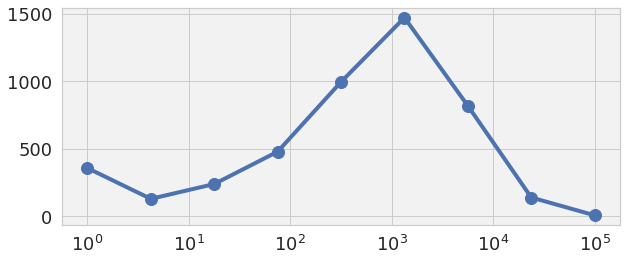

In [53]:
plt.figure(figsize=(10,4))
plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')

In [54]:
# models, weights, bias, mstmt, mstst = params
print ([p.shape if p is not None else None for p in best_params])

[(4627, 3), (4627, 72), (4627,), (4627, 72), (4627, 72)]


In [103]:
np.shape(param_batch[0])

(1000, 3)

In [118]:
voxel_batch_size=100

param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params]
# To initialize this module for prediction, need to take just first batch of voxels.
# Will eventually pass all voxels through in batches.
_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=None, input_shape=trn_stim_data.shape, aperture=1.0)

In [112]:
print(_fwrf_fn.weights.shape)

torch.Size([2, 432])


In [110]:
np.shape(val_stim_single_trial_data)

(142, 1, 227, 227)

In [119]:
# image are done redundantly for single trial data--but that's simpler

val_voxel_pred = get_predictions(val_stim_single_trial_data, _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=sample_batch_size)

val_size = 142
number of voxels = 11694
samples [  140:141  ] of 142, voxels [ 11600:11693 ] of 11694
---------------------------------------
total time = 234.623145s
sample throughput = 1.652276s/sample
voxel throughput = 0.020064s/voxel


In [120]:
#val_voxel_pred = voxel_pred[ordering[:data_size][shared_mask]]
val_cc  = np.zeros(shape=(nv), dtype=fpX)
for v in tqdm(range(nv)):    
    val_cc[v] = np.corrcoef(val_voxel_single_trial_data[:,v], val_voxel_pred[:,v])[0,1]  
val_cc = np.nan_to_num(val_cc)

100%|██████████| 11694/11694 [00:01<00:00, 7722.90it/s]


In [122]:
np.mean(val_cc)

0.04111412

In [57]:
param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params]

_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=None, input_shape=trn_stim_data.shape, aperture=1.0)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [58]:
# image are done redundantly for single trial data--but that's simpler
val_voxel_pred = get_predictions(val_stim_single_trial_data, _fmaps_fn, _fwrf_fn, best_params, sample_batch_size=sample_batch_size)

samples [  200:282  ] of 283, voxels [     0:499   ] of 4627

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


samples [  200:282  ] of 283, voxels [  4500:4626  ] of 4627
---------------------------------------
total time = 63.856630s
sample throughput = 0.225642s/sample
voxel throughput = 0.013801s/voxel


In [60]:
#val_voxel_pred = voxel_pred[ordering[:data_size][shared_mask]]
val_cc  = np.zeros(shape=(nv), dtype=fpX)
for v in tqdm(range(nv)):    
    val_cc[v] = np.corrcoef(val_voxel_single_trial_data[:,v], val_voxel_pred[:,v])[0,1]  
val_cc = np.nan_to_num(val_cc)

100%|██████████| 4627/4627 [00:00<00:00, 9542.63it/s]


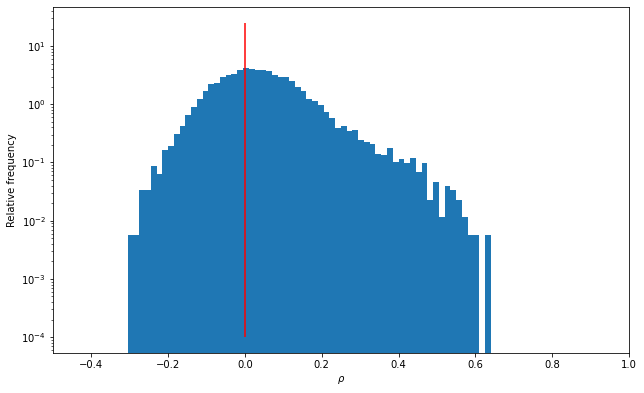

In [123]:
fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.5, 1.0])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

In [124]:
best_models = best_params[0]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

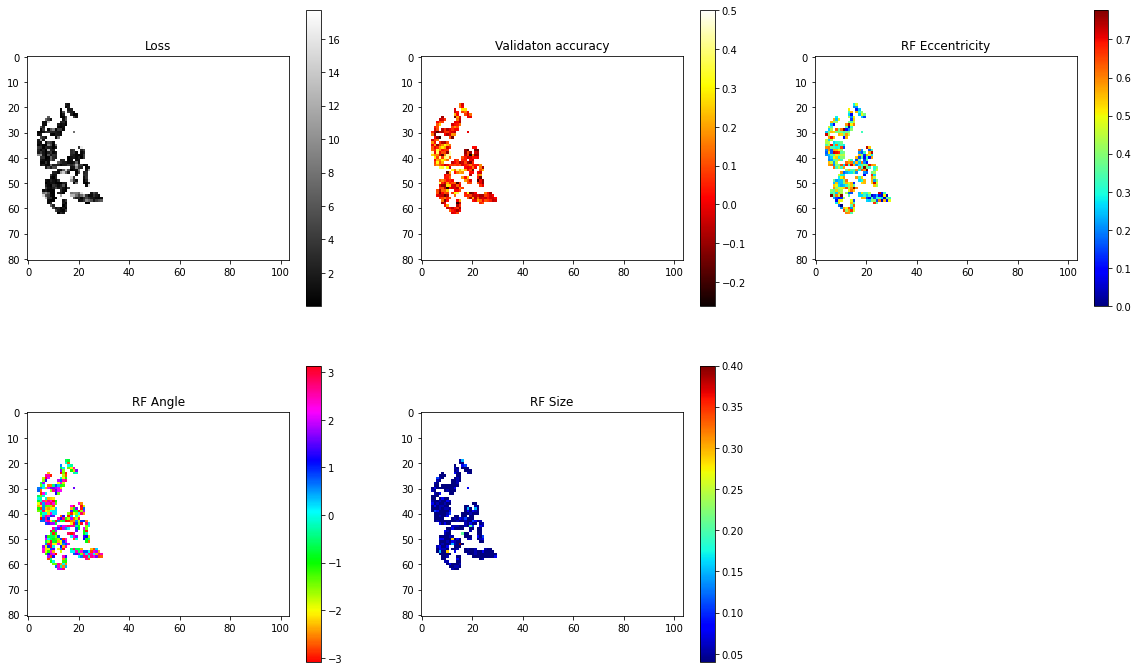

In [127]:
volume_loss = view_data(brain_nii_shape, voxel_idx, best_losses)
volume_cc   = view_data(brain_nii_shape, voxel_idx, val_cc, save_to=output_dir+"val_cc")
volume_ecc  = view_data(brain_nii_shape, voxel_idx, best_ecc, save_to=output_dir+"rf_ecc")
volume_ang  = view_data(brain_nii_shape, voxel_idx, best_ang, save_to=output_dir+"rf_ang")
volume_size = view_data(brain_nii_shape, voxel_idx, best_size, save_to=output_dir+"rf_size")

slice_idx = 40
fig = plt.figure(figsize=(20,12))
plt.subplot(2,3,1)
plt.title('Loss')
plt.imshow(volume_loss[:,:,slice_idx], cmap='gray', interpolation='None')
plt.colorbar()
plt.subplot(2,3,2)
plt.title('Validaton accuracy')
plt.imshow(volume_cc[:,:,slice_idx], cmap='hot', interpolation='None')
plt.colorbar()
plt.subplot(2,3,3)
plt.title('RF Eccentricity')
plt.imshow(volume_ecc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(2,3,4)
plt.title('RF Angle')
plt.imshow(volume_ang[:,:,slice_idx], cmap='hsv', interpolation='None')
plt.colorbar()
plt.subplot(2,3,5)
plt.title('RF Size')
plt.imshow(volume_size[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

# Save results to disk

In [128]:
torch.save({
    'lmask': lmask,
    'fmask': fmask,
    'tuning_masks': tuning_masks,
    'cyc_per_stim': cyc_per_stim,
    'aperture': aperture,
    'voxel_mask': voxel_mask,
    'brain_nii_shape': np.array(brain_nii_shape),
    'image_order': ordering,
    'voxel_index': voxel_idx,
    'voxel_roi': voxel_roi,
    'params': best_params,
    'lambdas': lambdas, 
    'best_lambdas': best_lambdas,
    'val_cc': val_cc,
    }, output_dir+'model_params')

In [67]:
## Previous version

#model_params = {
#    'lmask': lmask,
#    'fmask': fmask,
#    'tuning_masks': tuning_masks,
#    'cyc_per_stim': cyc_per_stim,
#    'aperture': aperture,
#    'voxel_mask': voxel_mask,
#    'brain_nii_shape': np.array(brain_nii_shape),
#    'image_order': ordering,
#    'voxel_index': voxel_idx,
#    'voxel_roi': voxel_roi,
#    'params': best_params,
#    'lambdas': lambdas, 
#    'best_lambdas': best_lambdas,
#    'val_cc': val_cc,
#    }

#print (timestamp)
#save_stuff(output_dir + "model_params", flatten_dict(model_params))

In [200]:
partition_val_cc   = np.ndarray(shape=(len(tuning_masks),)+(nv,), dtype=fpX) 
len(partition_val_cc[0])

11694

In [212]:
np.shape(best_params[1])

(11694, 432)

In [54]:
# models, weights, bias, mstmt, mstst = best_params
print ([p.shape if p is not None else None for p in best_params])

[(4627, 3), (4627, 72), (4627,), (4627, 72), (4627, 72)]


# Spatial frequency tuning

In [215]:
import gc
gc.collect()

sample_batch_size = 50 # 1000

# looking at model prediction within one feature map group here (one resolution at a time)
partition_val_cc   = np.ndarray(shape=(len(tuning_masks),)+(nv,), dtype=fpX)    
for l,rl in enumerate(tuning_masks):
    partition_params = [np.copy(p) for p in best_params]
    partition_params[1][:,:]   = 0
    # set to zero anything outside the masked region (isolating tuning for just this SF)
    partition_params[1][:, rl] = best_params[1][:, rl]
    ###
    # so these predictions are based on just the weights for the features at this particular SF.
    val_voxel_pred = get_predictions(val_stim_multi_trial_data, _fmaps_fn, _fwrf_fn, partition_params, sample_batch_size=sample_batch_size)
    #val_voxel_pred = voxel_pred[ordering[shared_mask]]
    for v in tqdm(range(nv)):    
        partition_val_cc[l,v] = np.corrcoef(val_voxel_pred[:,v], val_voxel_multi_trial_data[:,v])[0,1]

val_size = 103
number of voxels = 11694
samples [  100:102  ] of 103, voxels [ 11600:11693 ] of 11694
---------------------------------------
total time = 216.721034s
sample throughput = 2.104088s/sample
voxel throughput = 0.018533s/voxel


100%|██████████| 11694/11694 [00:01<00:00, 8730.17it/s]


val_size = 103
number of voxels = 11694
samples [  100:102  ] of 103, voxels [ 11600:11693 ] of 11694
---------------------------------------
total time = 215.857123s
sample throughput = 2.095700s/sample
voxel throughput = 0.018459s/voxel


100%|██████████| 11694/11694 [00:01<00:00, 8784.57it/s]


val_size = 103
number of voxels = 11694
samples [  100:102  ] of 103, voxels [ 11600:11693 ] of 11694
---------------------------------------
total time = 215.890951s
sample throughput = 2.096029s/sample
voxel throughput = 0.018462s/voxel


100%|██████████| 11694/11694 [00:01<00:00, 8681.85it/s]


val_size = 103
number of voxels = 11694
samples [  100:102  ] of 103, voxels [ 11600:11693 ] of 11694
---------------------------------------
total time = 215.478890s
sample throughput = 2.092028s/sample
voxel throughput = 0.018426s/voxel


100%|██████████| 11694/11694 [00:01<00:00, 8801.43it/s]


val_size = 103
number of voxels = 11694
samples [  100:102  ] of 103, voxels [ 11600:11693 ] of 11694
---------------------------------------
total time = 215.544243s
sample throughput = 2.092663s/sample
voxel throughput = 0.018432s/voxel


100%|██████████| 11694/11694 [00:01<00:00, 8811.98it/s]


val_size = 103
number of voxels = 11694
samples [  100:102  ] of 103, voxels [ 11600:11693 ] of 11694
---------------------------------------
total time = 215.629314s
sample throughput = 2.093488s/sample
voxel throughput = 0.018439s/voxel


100%|██████████| 11694/11694 [00:01<00:00, 8700.02it/s]


val_size = 103
number of voxels = 11694
samples [  100:102  ] of 103, voxels [   400:499   ] of 11694

KeyboardInterrupt: 

In [216]:
# Defining "tuning" based on which SF were most predictive of this voxel's response
# i.e. what proportion of variance did the features at each SF explain?
# this is a bit different than simply taking the weights for each SF as a direct measure of tuning 
# (maybe better in terms of invariance to orientation?)
partition_variance = np.square(np.nan_to_num(partition_val_cc))
var_min = np.min(partition_variance, axis=0, keepdims=True)
var_max = np.max(partition_variance, axis=0, keepdims=True)
tuning_scores = np.nan_to_num(np.sort((partition_variance - var_min) / (var_max - var_min), axis=0))
###
tuning = np.nan_to_num(partition_variance / np.sum(partition_variance, axis=0, keepdims=True))
tuning_argmax = np.argmax(partition_variance, axis=0)
tuning_spread = np.zeros_like(val_cc)
for v in tqdm(range(nv)):  
    tuning_spread[v] = np.interp(0.5, tuning_scores[:,v], np.linspace(0.,1.,len(tuning_scores),endpoint=True)[::-1])

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in square
  """
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 11694/11694 [00:00<00:00, 15131.41it/s]


0.63970256
argmax = 9 spread = 0.063927


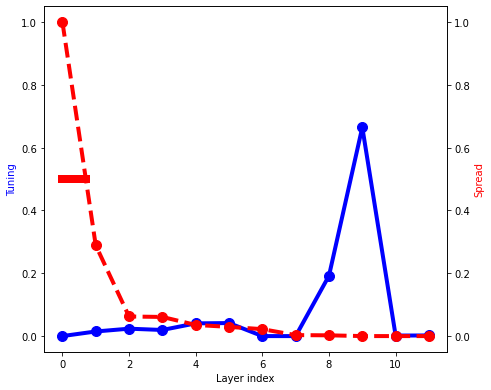

In [217]:
vidx = np.argsort(np.nan_to_num(val_cc))[-1]
print (val_cc[vidx])
print ('argmax = %d' % tuning_argmax[vidx], 'spread = %f' % tuning_spread[vidx])
fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.85, top=.95, wspace=0., hspace=0.)
ax1=plt.gca()
ax2=ax1.twinx()
ax1.plot(tuning[:,vidx], marker='o', ms=10, color='b', lw=4)
ax1.set_ylim([-.05, 1.05])
ax1.set_xlabel('Layer index')
ax1.set_ylabel('Tuning', color='b')
ax2.plot(tuning_scores[::-1,vidx], marker='o', lw=4, linestyle='--', ms=10, color='r')
ax2.plot([0, (len(tuning)-1)*(tuning_spread[vidx])], [.5, .5], color='r', lw=8)
ax2.set_ylabel('Spread', color='r')
ax2.set_ylim([-.05,1.05])
ax2.grid(False)

In [218]:
filename = output_dir + "tuning_and_spread_example_%s%s"  % (vidx, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

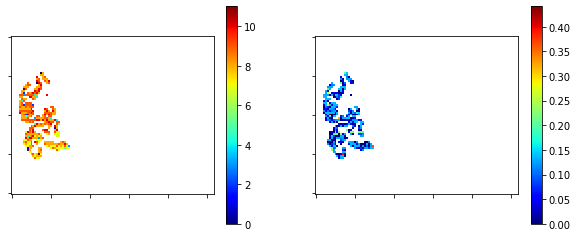

In [219]:
volume_brain_tuning  = view_data(brain_nii_shape, voxel_idx, tuning_argmax, save_to=output_dir+"layer_tuning")
volume_brain_spread  = view_data(brain_nii_shape, voxel_idx, tuning_spread, save_to=output_dir+"layer_spread")

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(volume_brain_tuning[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,2,2)
plt.imshow(volume_brain_spread[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [220]:
torch.save({
    'voxel_mask': voxel_mask,
    'brain_nii_shape': np.array(brain_nii_shape),
    'voxel_index': voxel_idx,
    'voxel_roi': voxel_roi, 
    'val_cc': val_cc,
    'cyc_per_stim': cyc_per_stim,
    'part_val_cc': partition_val_cc
    }, output_dir + 'model_freq_tuning')

# Orientation tuning

In [221]:
ori_tuning_masks = [np.zeros_like(tuning_masks[0]) for i in range(n_ori)]
for k,m in enumerate(ori_tuning_masks):
    m[range(k,len(m),n_ori)] = True
#print (ori_tuning_masks)

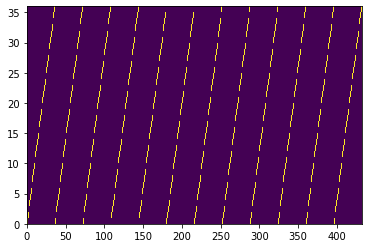

In [224]:
plt.figure();
plt.pcolormesh(ori_tuning_masks)

In [226]:
sample_batch_size = 20 # 1000

partition_val_cc   = np.ndarray(shape=(len(ori_tuning_masks),)+(nv,), dtype=fpX)    
for l,rl in enumerate(ori_tuning_masks):
    partition_params = [np.copy(p) for p in best_params]
    partition_params[1][:,:]   = 0
    partition_params[1][:, rl] = best_params[1][:, rl]
    ###
    val_voxel_pred = get_predictions(val_stim_multi_trial_data, _fmaps_fn, _fwrf_fn, partition_params, sample_batch_size=sample_batch_size)
    #val_voxel_pred = voxel_pred[ordering[shared_mask]]
    for v in tqdm(range(nv)):    
        partition_val_cc[l,v] = np.corrcoef(val_voxel_pred[:,v], val_voxel_multi_trial_data[:,v])[0,1]

val_size = 103
number of voxels = 11694
samples [  100:102  ] of 103, voxels [  2100:2199  ] of 11694

KeyboardInterrupt: 

In [227]:
partition_variance = np.square(np.nan_to_num(partition_val_cc))
var_min = np.min(partition_variance, axis=0, keepdims=True)
var_max = np.max(partition_variance, axis=0, keepdims=True)
tuning_scores = np.nan_to_num(np.sort((partition_variance - var_min) / (var_max - var_min), axis=0))
###
tuning = np.nan_to_num(partition_variance / np.sum(partition_variance, axis=0, keepdims=True))
tuning_argmax = np.argmax(partition_variance, axis=0)
tuning_spread = np.zeros_like(val_cc)
for v in tqdm(range(nv)):  
    tuning_spread[v] = np.interp(0.5, tuning_scores[:,v], np.linspace(0.,1.,len(tuning_scores),endpoint=True)[::-1])

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in square
  """Entry point for launching an IPython kernel.
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
100%|██████████| 11694/11694 [00:00<00:00, 16322.04it/s]


0.41565105
argmax = 4 spread = 0.415081


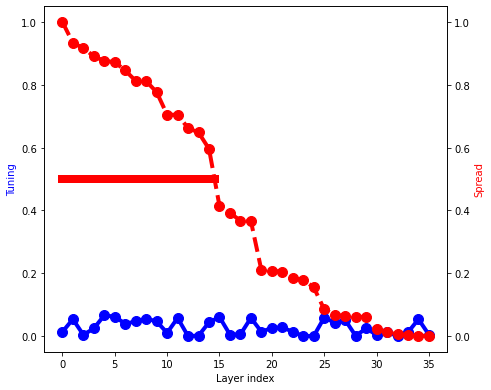

In [228]:
vidx = np.argsort(np.nan_to_num(val_cc))[-102]
print (val_cc[vidx])
print ('argmax = %d' % tuning_argmax[vidx], 'spread = %f' % tuning_spread[vidx])
fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.85, top=.95, wspace=0., hspace=0.)
ax1=plt.gca()
ax2=ax1.twinx()
ax1.plot(np.arange(0, len(ori_tuning_masks)), tuning[:,vidx], marker='o', ms=10, color='b', lw=4)
ax1.set_ylim([-.05, 1.05])
ax1.set_xlabel('Layer index')
ax1.set_ylabel('Tuning', color='b')
ax2.plot(np.arange(0, len(ori_tuning_masks)), tuning_scores[:,vidx][::-1], marker='o', lw=4, linestyle='--', ms=10, color='r')
ax2.plot([0, (len(ori_tuning_masks)-1)*(tuning_spread[vidx])], [.5, .5], color='r', lw=8)
ax2.set_ylabel('Spread', color='r')
ax2.set_ylim([-.05,1.05])
ax2.grid(False)

In [229]:
filename = output_dir + "tuning_and_spread_example_ori_%s%s"  % (vidx, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

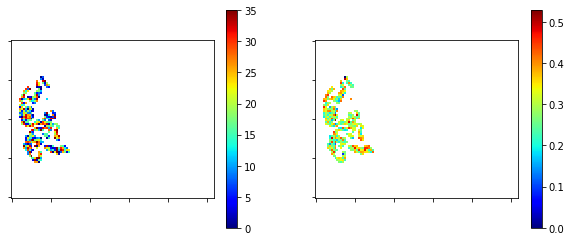

In [230]:
volume_brain_tuning  = view_data(brain_nii_shape, voxel_idx, tuning_argmax, save_to=output_dir+"layer_orientation_tuning")
volume_brain_spread  = view_data(brain_nii_shape, voxel_idx, tuning_spread, save_to=output_dir+"layer_orientation_spread")

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(volume_brain_tuning[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,2,2)
plt.imshow(volume_brain_spread[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [231]:
torch.save({
    'voxel_mask': voxel_mask,
    'brain_nii_shape': np.array(brain_nii_shape),
    'voxel_index': voxel_idx,
    'voxel_roi': voxel_roi, 
    'val_cc': val_cc,
    'part_val_cc': partition_val_cc
    }, output_dir + 'model_orientation_tuning')

In [17]:
## Using original gaborizer version w zero padding
from src.gabor_feature_extractor_ORIG import Gaborizer
# n_ori=6
n_ori = 36
cyc_per_stim = logspace(12)(3., 72.) # 6-92
_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=4.13, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

_fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

torch.Size([36, 1, 12, 12])
torch.Size([36, 1, 12, 12])


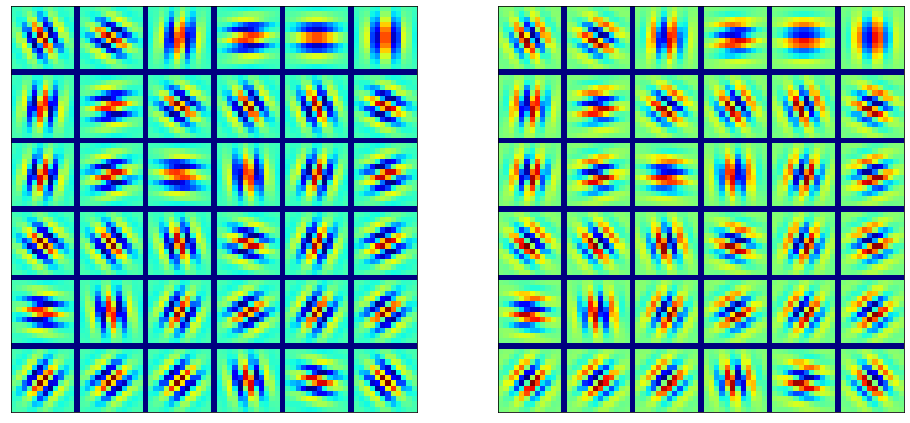

In [18]:
# Printing real and complex parts of the filters: 90 deg out of phase.

for _p in _fmaps_fn.parameters():
    print (_p.size())

plt.figure(figsize=(16, 8))
for k,_p in enumerate(_fmaps_fn.parameters()):
    plt.subplot(1,2,k+1)
 
    plt.imshow(pnu.mosaic_vis(get_value(_p)[:,0], pad=1), interpolation='None', cmap='jet')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  

In [19]:
# just to measure the size of these...pass a bit of the data through Gaborizer and get out tensor for each feature map.
_x = torch.tensor(trn_stim_data[:10]).to(device) # the input variable.
_fmaps = _gaborizer(_x)

for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([10, 36, 13, 13])
torch.Size([10, 36, 18, 18])
torch.Size([10, 36, 23, 23])
torch.Size([10, 36, 30, 30])
torch.Size([10, 36, 40, 40])
torch.Size([10, 36, 54, 54])
torch.Size([10, 36, 71, 71])
torch.Size([10, 36, 95, 95])
torch.Size([10, 36, 126, 126])
torch.Size([10, 36, 168, 168])
torch.Size([10, 36, 224, 224])
torch.Size([10, 36, 298, 298])


0.024236746
0.020703657
0.01776123
0.01426054
0.012219707
0.010465811
0.008597871
0.006911251
0.005721523
0.0047101066
0.00362907


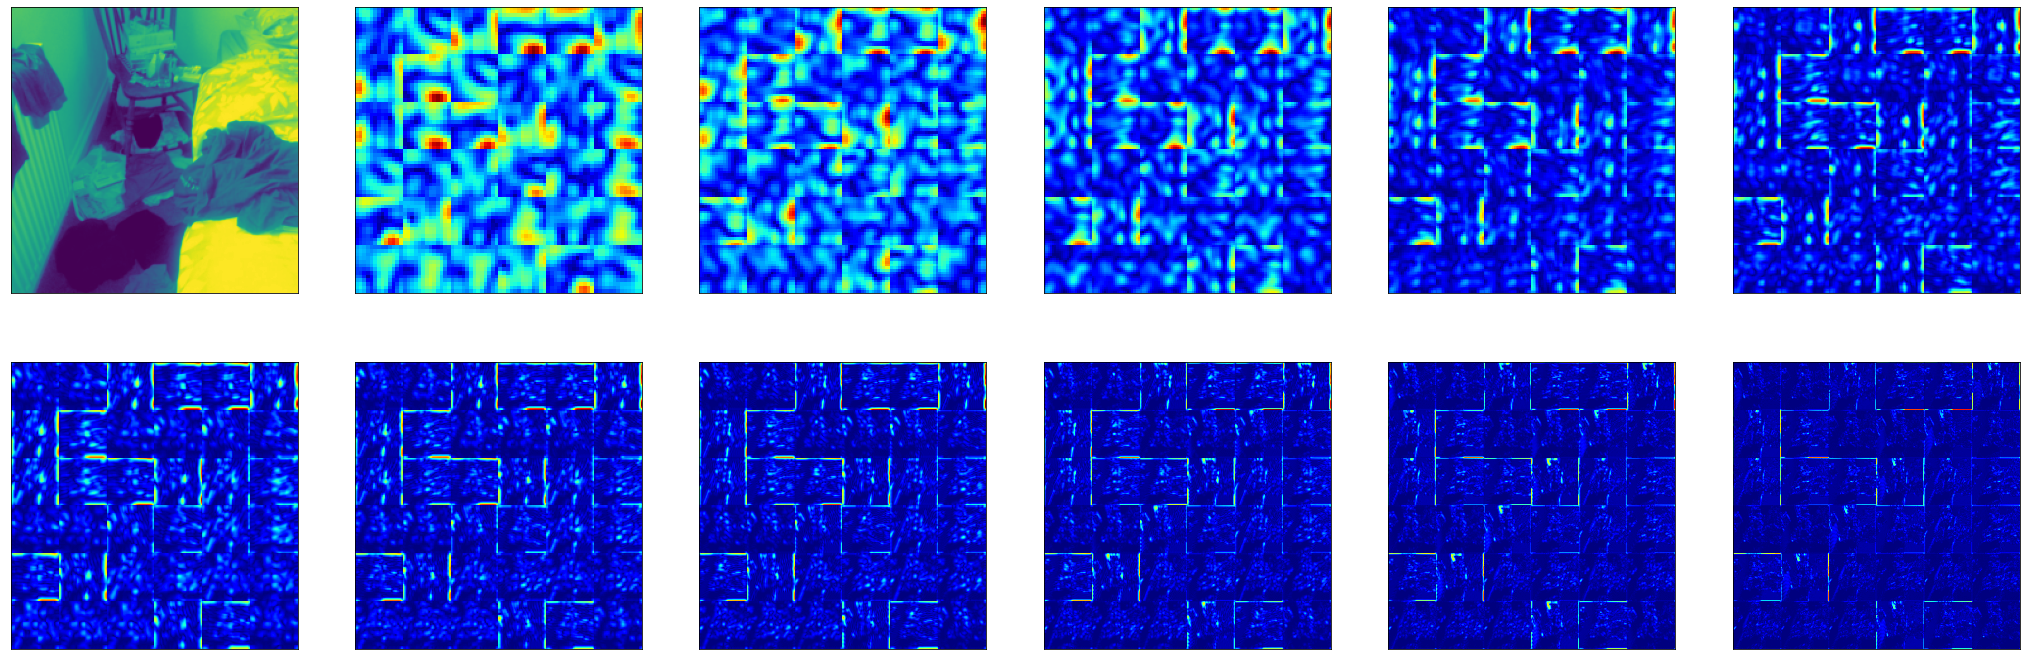

In [20]:
## Seem to be more edge artifacts when it's done this way

plt.figure(figsize=(36,12))
image_ind=9
plt.subplot(2,6,1)
plt.imshow(np.squeeze(trn_stim_data[image_ind]))
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)  

# looping over resolutions
for k,_fm in enumerate(_fmaps[:11]):
    plt.subplot(2,6,k+2)
    plt.imshow(pnu.mosaic_vis(get_value(_fm)[image_ind], pad=0), interpolation='None', cmap='jet')
    print(np.mean(get_value(_fm)[image_ind]))
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  

elapsed =0.019235
elapsed =0.003533


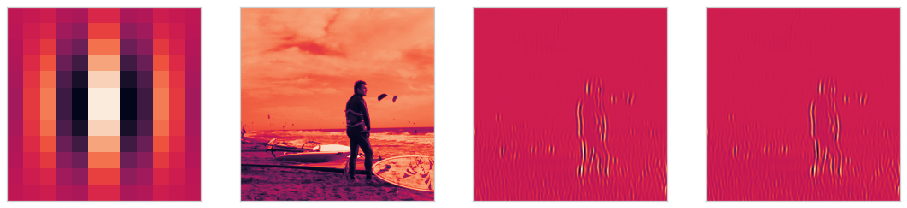

In [99]:

_p = next(_fmaps_fn.parameters())
kernel = get_value(_p)[5,:,:,:]
kernel = kernel[:,np.newaxis,:,:,]

image = trn_stim_data[0,:,:,:]
image = image[:,np.newaxis,:,:]


pad_sz = int(np.shape(kernel)[1]/2)

t = time.time()
convimage1 = F.conv2d(T.tensor(image),T.tensor(kernel), stride=1, padding=pad_sz)
elapsed = time.time() - t
print('elapsed =%.6f'%elapsed)

t = time.time()
c = L.Conv2d(1,1,np.shape(kernel)[2],stride=1, padding=pad_sz, padding_mode='reflect')
c.weight.data = T.tensor(kernel)
convimage2 = c(T.tensor(image))
elapsed = time.time() - t
print('elapsed =%.6f'%elapsed)


plt.figure(figsize=(16,16));

plt.subplot(1,4,1)
plt.pcolormesh(np.squeeze(kernel))
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()

plt.subplot(1,4,2)
plt.pcolormesh(image[0,0,:,:])
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()

plt.subplot(1,4,3)
plt.pcolormesh(np.squeeze(convimage1.detach().numpy()))
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()

plt.subplot(1,4,4)
plt.pcolormesh(np.squeeze(convimage2.detach().numpy()))
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()